## ViscoAcoustic Modelling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import matplotlib.lines as mlines
import matplotlib.animation as animation
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter


### Source Function: A Ricker Wavelet

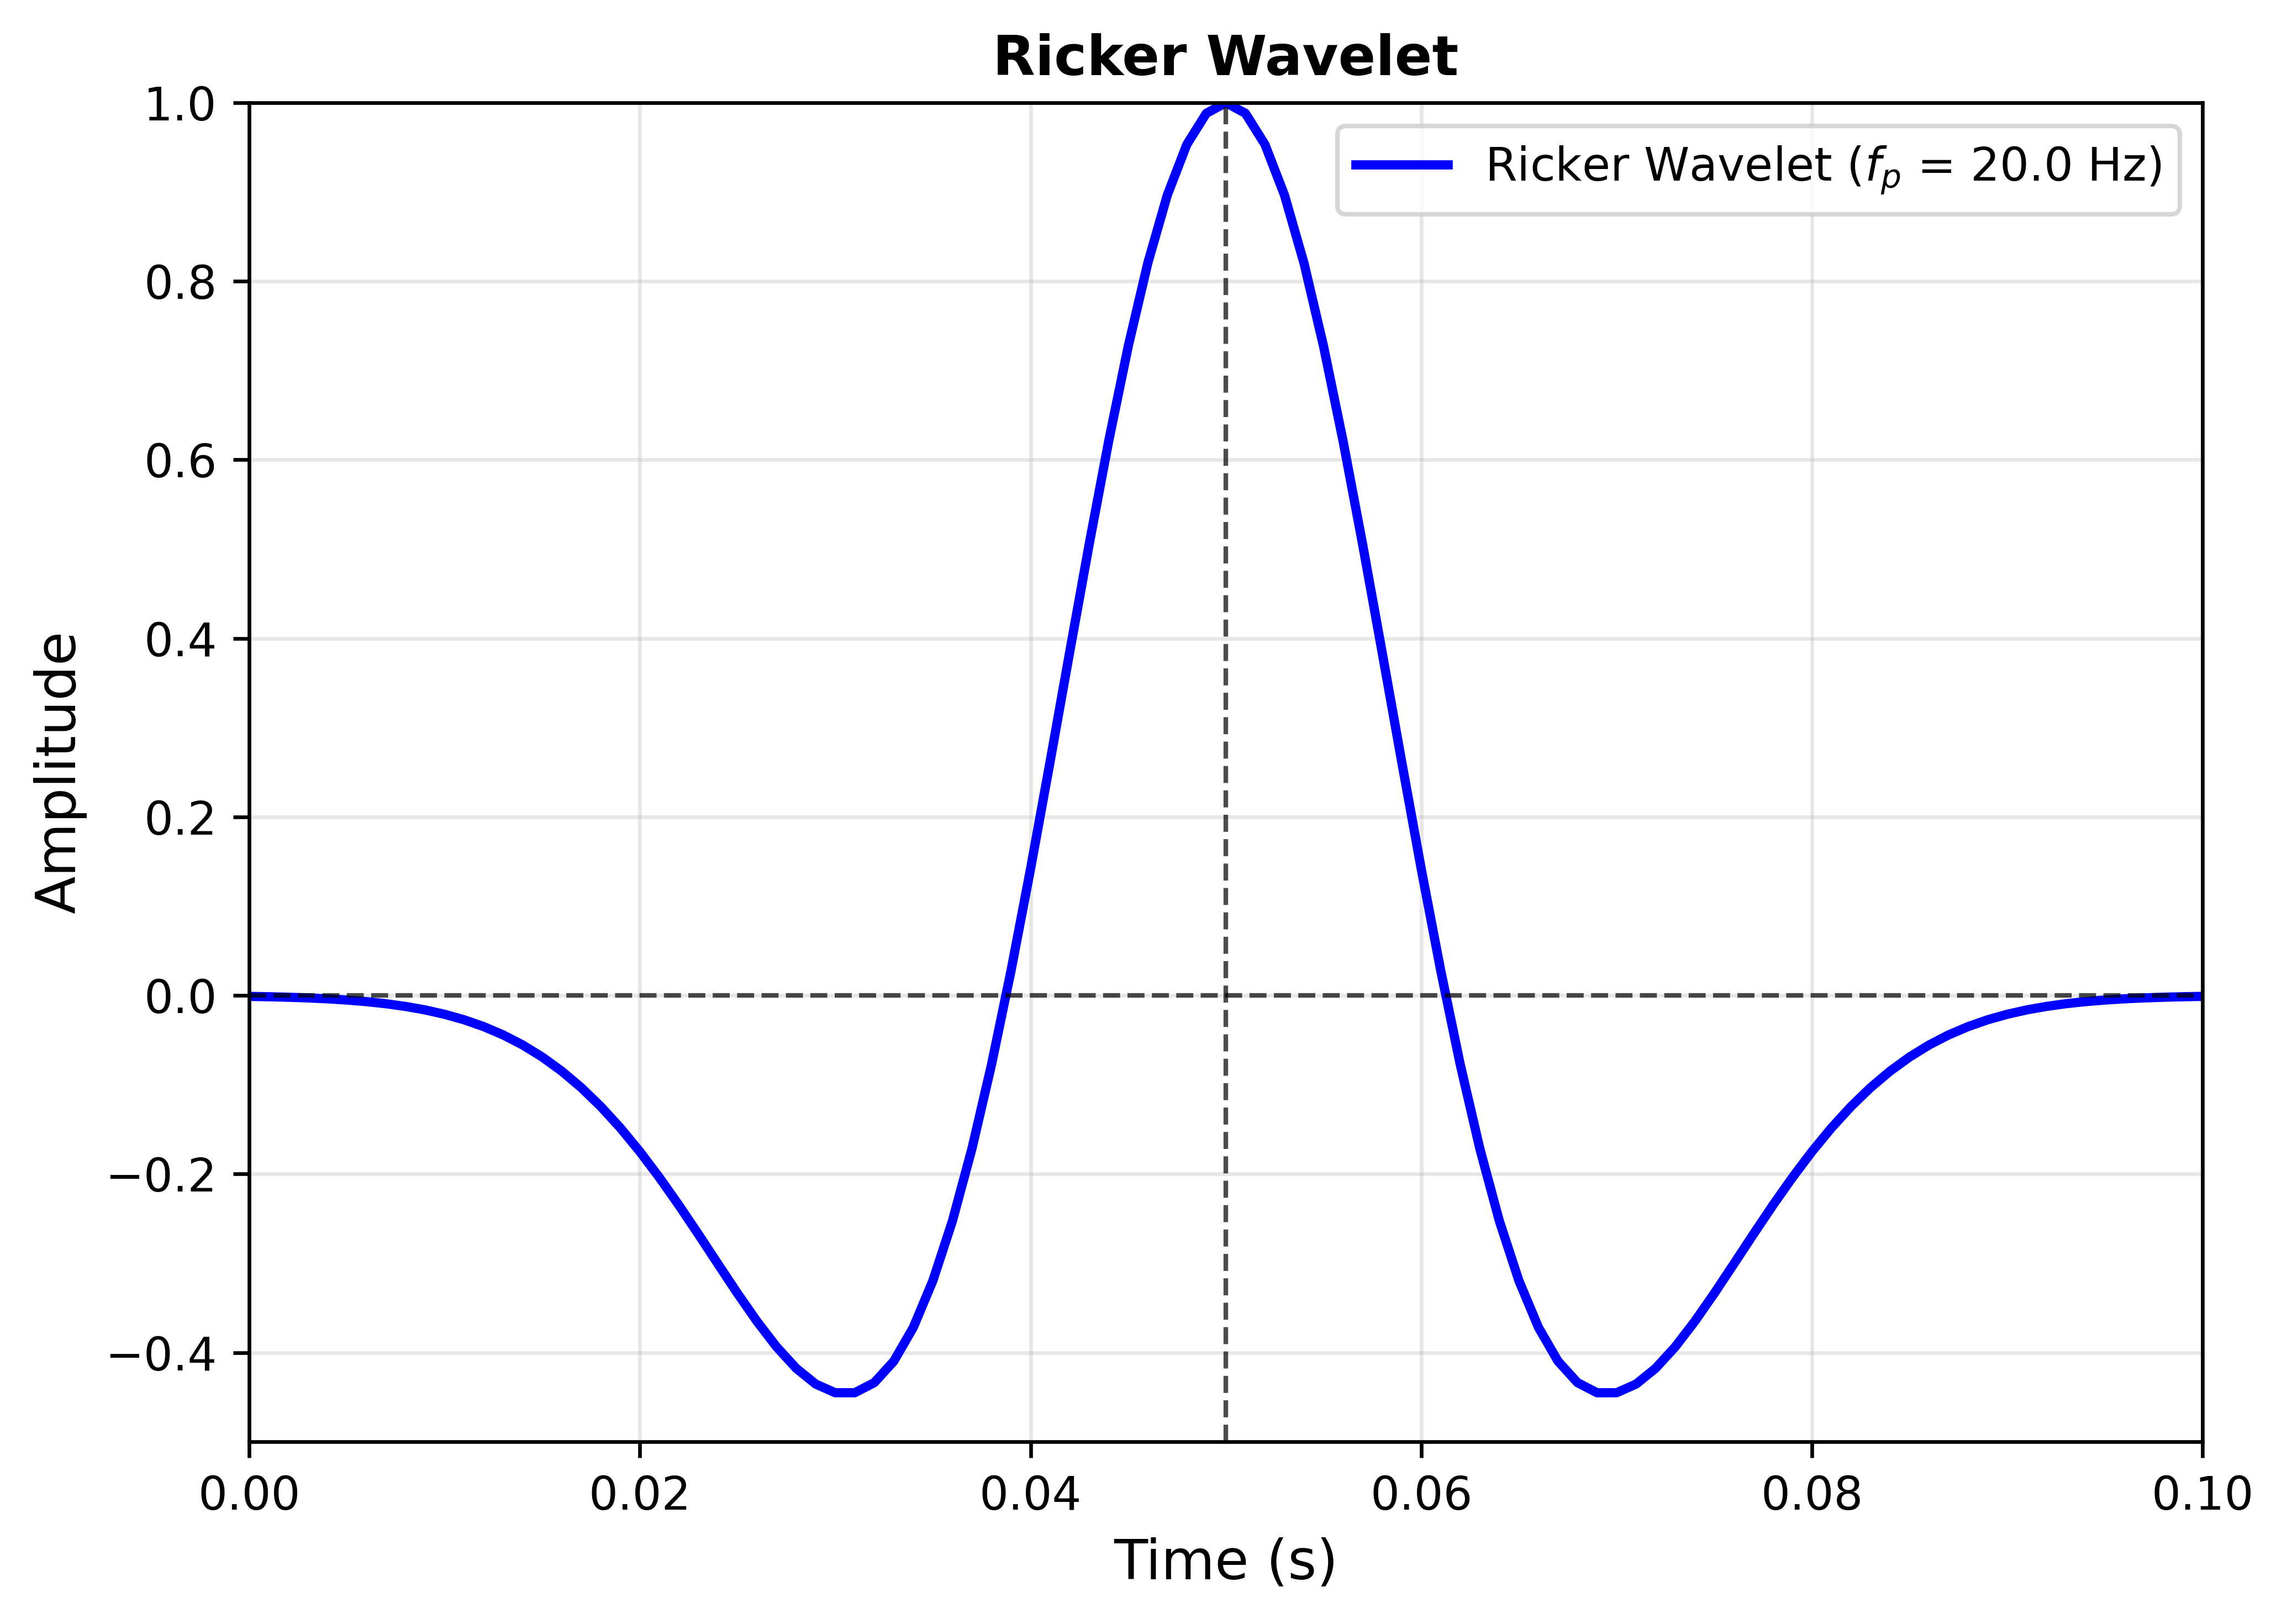

Wavelet parameters:
  Peak frequency:    20.0 Hz
  Time step:         0.001 s
  Number of samples: 1001
  Total duration:    1.000 s
  Maximum amplitude: 1.000
  Time of peak:      0.0500 s


In [2]:
##########################################
# Function for normalized Ricker wavelet #
##########################################
def ricker(fp, dt, nt):
    """
    Generate a normalized Ricker wavelet.
    
    The Ricker wavelet is a commonly used seismic wavelet that represents
    the second derivative of a Gaussian function. It's characterized by
    its peak frequency and has both positive and negative lobes.
    
    Parameters:
    -----------
    fp (float): Peak frequency of the wavelet (Hz).
                This is the dominant frequency of the wavelet.
    dt (float): Time step/sampling interval (s).
                Must be small enough to properly sample the wavelet.
    nt (int): Number of time samples.
              Determines the length of the generated wavelet.
    
    Returns:
    --------
    numpy.ndarray: Normalized Ricker wavelet with maximum amplitude of 1.
    
    Raises:
    -------
    ValueError: If dt is too large for accurate sampling of the given frequency.
    """
    # Check for numerical stability and accurate sampling
    # The Nyquist criterion suggests dt should be much smaller than the period
    if dt > 1. / (3. * fp):
        raise ValueError("dt > 1 / (3 * fp): Time step too large for the given peak frequency.")
    
    # Calculate the central time (period of the peak frequency)
    # This centers the wavelet in time domain
    t0 = 1. / fp    # Central time (where the wavelet is symmetric)
    
    # Generate the time vector, centered around t0
    # This creates a symmetric time axis with the wavelet peak at the center
    t = np.linspace(0*dt, (nt - 1)*dt, nt)
    
    # Compute the Ricker wavelet using the standard formula:
    # w(t) = (1 - 2π²f²t²) * exp(-π²f²t²)
    # where f is the peak frequency and t is time
    x  = (np.pi * fp * (t-t0)) ** 2     # π²f²t²
    wl = (1. - 2. * x) * np.exp(-x)  # (1 - 2x) * exp(-x) where x = π²f²t²
    
    # Normalize the wavelet to have a maximum amplitude of 1
    # This ensures consistent amplitude regardless of frequency
    # wl /= np.max(np.abs(wl))  # Use abs() to handle potential negative peaks
    
    return wl

################################
# Example usage and parameters #
################################
fp = 20.0   # Peak frequency in Hz (25 Hz dominant frequency)
dt = 0.001  # Time step in seconds (1 ms sampling)
nt = 1001   # Number of samples (creates ~1 second of data)
wavelet = ricker(fp, dt, nt)
t       = np.linspace(0*dt, (nt - 1)*dt, nt)   # Time vector in seconds

########################
# Plotting the wavelet #
########################
plt.figure(figsize=(7, 5), dpi=600)  # Set figure size for better visualization
plt.plot(t, wavelet, 'b-', linewidth=2, label=f'Ricker Wavelet ($f_p$ = {fp} Hz)')
plt.title("Ricker Wavelet", fontsize=12, fontweight='bold')
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.grid(True, alpha=0.3)  # Add grid for better readability
plt.legend()

# Set reasonable axis limits to focus on the main wavelet
# Adjust these based on your specific needs
plt.xlim(0, 0.1)  # Show ±0.1 seconds around the peak
plt.ylim(-0.5, 1.0)  # Show full amplitude range with some margin

# Add zero line for reference
plt.axhline(y=0, color='k', linestyle='--', alpha=0.7, lw=1.0)
plt.axvline(x=1/fp, color='k', linestyle='--', alpha=0.7, lw=1.0)

plt.tight_layout()  # Improve spacing
plt.savefig('Ricker_Wavelet.png', dpi=600, bbox_inches='tight')
plt.show()

#############################################################
# Print some useful information about the generated wavelet #
#############################################################
print(f"Wavelet parameters:")
print(f"  Peak frequency:    {fp} Hz")
print(f"  Time step:         {dt} s")
print(f"  Number of samples: {nt}")
print(f"  Total duration:    {dt * (nt - 1):.3f} s")
print(f"  Maximum amplitude: {np.max(np.abs(wavelet)):.3f}")
print(f"  Time of peak:      {t[np.argmax(np.abs(wavelet))]:.4f} s")


### Ricker Wavelet, Its Hilbert and Envelope

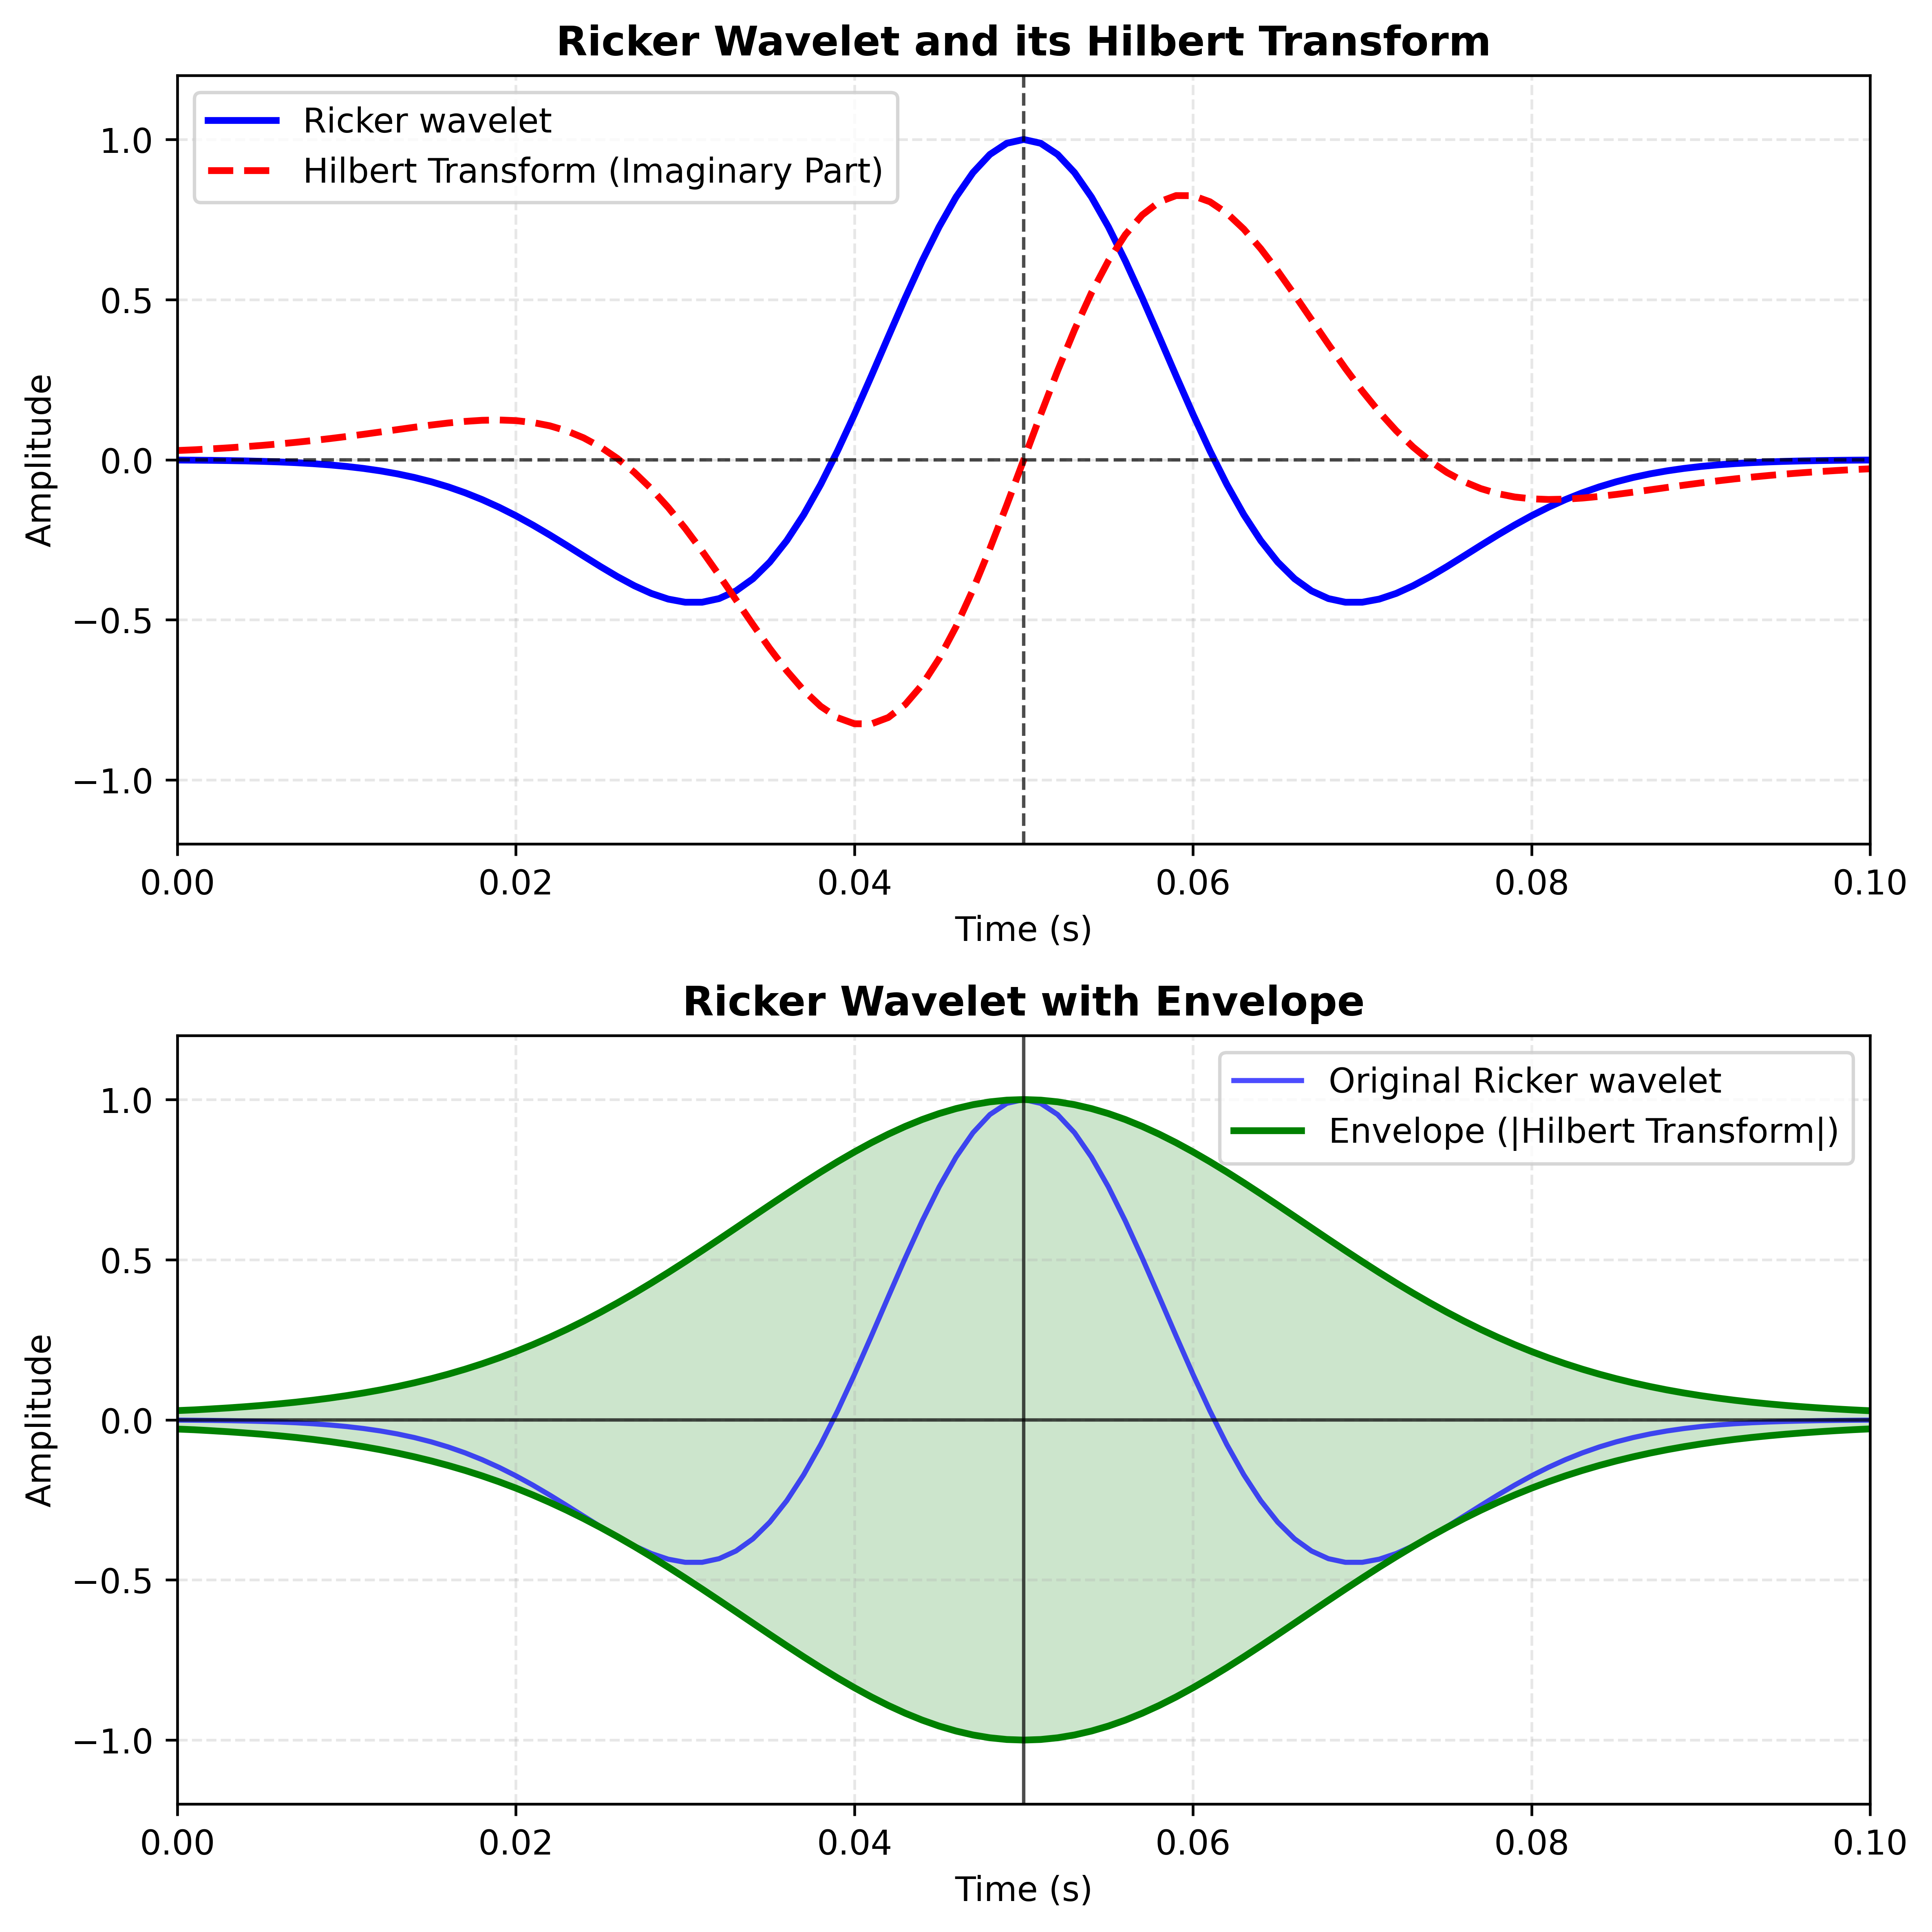

Wavelet Analysis Results:
  Original wavelet peak amplitude:  1.0000
  Hilbert transform peak amplitude: 0.8248
  Envelope peak amplitude:          1.0000
  Time window displayed:            ±0.1000 seconds
  Peak frequency:                   20.0 Hz

Analytical Signal Properties:
  Mean instantaneous frequency: 0.99 Hz
  Peak instantaneous amplitude: 1.0000


In [3]:
# Generate the source time function
wavelet = ricker(fp, dt, nt)
time    = np.linspace(0, dt * (nt - 1), nt)  # Time vector in seconds

#################################
# Compute the Hilbert transform #
#################################
# The Hilbert transform creates the quadrature (90° phase-shifted) component
# of the signal, which is useful for envelope detection and instantaneous frequency
# Hilbert shifts all the frequency components of a real signal by −90° for positive frequencies and +90° for negative frequencies.
hilbert_transform = hilbert(wavelet)
imaginary_part    = np.imag(hilbert_transform)  # Extract imaginary part (quadrature component)

###################
# Create the plot #
###################
plt.figure(figsize=(8, 8), dpi=600)
plt.subplot(2, 1, 1)
plt.plot(time, wavelet, 'b-', linewidth=2, label="Ricker wavelet")
plt.plot(time, imaginary_part, 'r--', linewidth=2, label="Hilbert Transform (Imaginary Part)")
plt.legend()
plt.grid(True, alpha=0.3, linestyle='--')
plt.title("Ricker Wavelet and its Hilbert Transform", fontsize=12, fontweight='bold')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Set appropriate axis limits based on the actual data
# Focus on the main wavelet energy (typically within ±2 periods)
time_window = 2 / fp  # ±2 periods around the center
plt.xlim(0, time_window)
plt.ylim(-1.2, 1.2)

# Add reference lines
plt.axhline(y=0, color='k', linestyle='--', alpha=0.7, lw=1.)
plt.axvline(x=1/fp, color='k', linestyle='--', alpha=0.7, lw=1.)

##########################################################
# Plot the envelope (magnitude of the analytical signal) #
##########################################################
plt.subplot(2, 1, 2)
envelope = np.abs(hilbert_transform)  # Envelope is the magnitude of the analytical signal
plt.plot(time, wavelet, 'b-', linewidth=1.5, alpha=0.7, label="Original Ricker wavelet")
plt.plot(time, envelope, 'g-', linewidth=2, label="Envelope (|Hilbert Transform|)")
plt.plot(time, -envelope, 'g-', linewidth=2)  # Show negative envelope too
plt.fill_between(time, -envelope, envelope, alpha=0.2, color='green')

plt.legend()
plt.grid(True, alpha=0.3, linestyle='--')
plt.title("Ricker Wavelet with Envelope", fontsize=12, fontweight='bold')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.xlim(0, time_window)
plt.ylim(-1.2, 1.2) 

# Add reference lines
plt.axhline(y=0, color='k', linestyle='-', alpha=0.7, lw=1.)
plt.axvline(x=1/fp, color='k', linestyle='-', alpha=0.7, lw=1.)

plt.tight_layout()  # Improve spacing between subplots
plt.savefig('Ricker_Wavelet_Hilbert_Transform.png', dpi=600, bbox_inches='tight')
plt.show()

#################################################
# Print useful information about the transforms #
#################################################
print("Wavelet Analysis Results:")
print(f"  Original wavelet peak amplitude:  {np.max(np.abs(wavelet)):.4f}")
print(f"  Hilbert transform peak amplitude: {np.max(np.abs(imaginary_part)):.4f}")
print(f"  Envelope peak amplitude:          {np.max(envelope):.4f}")
print(f"  Time window displayed:            ±{time_window:.4f} seconds")
print(f"  Peak frequency:                   {fp} Hz")

############################################
# Display the analytical signal properties #
############################################
analytical_signal       = hilbert_transform       # This is the complex analytical signal
instantaneous_amplitude = np.abs(analytical_signal)
instantaneous_phase     = np.unwrap(np.angle(analytical_signal))
instantaneous_frequency = np.diff(instantaneous_phase) / (2 * np.pi * dt)

print(f"\nAnalytical Signal Properties:")
print(f"  Mean instantaneous frequency: {np.mean(instantaneous_frequency):.2f} Hz")
print(f"  Peak instantaneous amplitude: {np.max(instantaneous_amplitude):.4f}")


### Mur Absorbing Boundary Conditions (ABC)

In [4]:
######################
# ABC's coefficients #
######################

def abc_coef(r, r2):
    """
    Compute the coefficients for Mur Absorbing Boundary Conditions (ABC).
    
    The Mur ABC is a first-order approximation to the exact radiation boundary
    condition for wave equations. It minimizes reflections at computational
    domain boundaries by approximating the outgoing wave behavior.
    
    The ABC formula is typically:
    ∂u/∂t + c*∂u/∂n = higher-order terms
    
    Where the coefficients relate to the discretized form of this equation.
    
    Parameters:
    -----------
    r  (float or numpy.ndarray): The Courant number (c * dt / dx), where:
                                - c is the wave speed
                                - dt is the time step
                                - dx is the spatial grid spacing
                                Must satisfy stability condition (typically r ≤ 1)
    r2 (float or numpy.ndarray): The square of the Courant number (r²).
                                This is passed separately for computational efficiency.
    
    Returns:
    --------
    tuple: (c1, c2, c3, c4) - Four coefficients used in Mur ABC calculations:
        c1 (float): Coefficient for the current time step boundary value
        c2 (float): Coefficient for the previous time step boundary value  
        c3 (float): Coefficient for the spatial derivative term
        c4 (float): Coefficient for the second-order correction term
    
    Notes:
    ------
    - The function assumes r > 0 for physical wave propagation
    - For stability, typically requires r ≤ 1 (CFL condition)
    - The coefficients are derived from finite difference approximation of Mur ABC
    """
    
    # Input validation for physical consistency
    if np.any(r <= 0):
        raise ValueError("Courant number 'r' must be positive for physical wave propagation")
    
    if np.any(r > 1.0):
        print("Warning: Courant number r > 1 may cause numerical instability")
    
    # Verify consistency between r and r2
    if not np.allclose(r**2, r2, rtol=1e-10):
        raise ValueError("Inconsistency detected: r² does not match the provided r2 parameter")
    
    # Compute the common denominator to avoid repeated division operations
    # This denominator appears in multiple coefficient calculations
    denom = 1.0 / (r + 1.0)    # Using 1.0 for consistent floating-point arithmetic
    
    # Calculate Mur ABC coefficients based on finite difference discretization
    # These coefficients come from the discrete approximation of the radiation condition
    
    c1 = -1.0                   # Coefficient for current boundary value
                                # (negative sign indicates outgoing wave assumption)
    
    c2 = (r - 1.0) * denom      # Coefficient for previous time step boundary value
                                # Accounts for the time evolution of the boundary
    
    c3 = (2.0 - r2) * denom     # Coefficient for first spatial derivative term
#     c3 = 2.0 * denom     # Represents the main absorption mechanism
    
    c4 = 0.5 * r2 * denom       # Coefficient for second-order correction term
                                # Improves accuracy for higher frequencies
    
    return c1, c2, c3, c4
    

### ViscoAcoustic Modeling

In [5]:
def ViscoAcousticModeling(model, mode, spatial_grid, source, temporal_grid):
    """
    Time-domain complex-valued viscoacoustic wave propagation modeling with dispersion and dissipation.
    
    This function implements the Kolsky-Futterman (KF) model for viscoacoustic 
    wave propagation, which can handle both frequency-independent Q (dissipation) 
    and frequency-dependent dispersion effects.
    
    Parameters:
    -----------
    model : tuple
        (c0, Q) where:
        - c0: Wave velocity (m/s) - scalar or 2D array
        - Q: Quality factor for attenuation - scalar or 2D array
    
    mode : list
        [dispersion_flag, dissipation_flag] where:
        - dispersion_flag: 1 to enable dispersion, 0 to disable
        - dissipation_flag: 1 to enable dissipation, 0 to disable
    
    spatial_grid : tuple
        (nz, nx, h) where:
        - nz: Number of grid points in z-direction
        - nx: Number of grid points in x-direction  
        - h: Spatial grid spacing (m)
    
    source : tuple
        (wavelet, izs, ixs, fp) where:
        - wavelet: Source time function
        - izs, ixs: Source position indices
        - fp: Dominant frequency (Hz)
    
    temporal_grid : tuple
        (nt, dt) where:
        - nt: Number of time steps
        - dt: Time step (s)
    
    Returns:
    --------
    numpy.ndarray: Complex wavefield U(nz, nx, nt)

    Notes:
    ------
    - Dissipation: is the loss of wave energy to the medium, usually converting it into heat or other forms of energy.
                 Cause: Friction, viscosity, electrical resistance, or any irreversible process.
                 Effect on wave: The wave amplitude decreases with distance. The wave shape remains essentially the same, but weaker.
    - Dispersion: is the the dependence of wave velocity on frequency (or wavelength).
                 Cause: Properties of the medium that make different frequencies travel at different speeds.
                 Effect on wave: The wave spreads out in time/space because its frequency components travel differently. The wave energy is not lost — just redistributed.
    """

    #########################################
    # Extract and validate model parameters #
    #########################################
    c0, Q = model   # Wave velocity and Quality Factor
    
    # Handle both homogeneous and heterogeneous velocity models
    if np.isscalar(c0):
        print(f"Using homogeneous velocity model: {c0} m/s")
    else:
        print(f"Using heterogeneous (or layered homogeneous) velocity model: {c0.shape}")
        print(f"  Velocity range: {np.min(c0):.0f} - {np.max(c0):.0f} m/s")
    
    if np.isscalar(Q):
        print(f"Using homogeneous Q model: {Q}")
    else:
        print(f"Using heterogeneous (or layered homogeneous) Q model: {Q.shape}")
        print(f"  Q range: {np.min(Q):.0f} - {np.max(Q):.0f}")
        
    ###################################
    # Extract spatial grid parameters #
    ###################################
    nz, nx, h = spatial_grid
    print(f"Grid dimensions: {nz} x {nx}, spacing: {h} m")

    #########################################
    # Extract and process source parameters #
    #########################################
    wavelet_real, izs, ixs, fp = source
    
    # Apply Hilbert transform to create analytical source signal
    # This enables complex wavefield modeling for viscoacoustic effects
    src = hilbert(wavelet_real)
    print(f"Source location: ({izs}, {ixs}), dominant frequency: {fp} Hz")

    ####################################
    # Extract temporal grid parameters #
    ####################################
    nt, dt = temporal_grid
    print(f"Time steps: {nt}, dt: {dt} s, total time: {(nt-1)*dt} s")

    ##############################################
    # Set Kolsky-Futterman (KF) model parameters #
    ##############################################
    if mode[0] != 0:  # Dispersion enabled
        # Original KF model parameters for dispersion
        a, b, d = 5.7356, -762.16, 46054
#         a, b, d = 3.7801, -110.6870, 1111.5
        print('Dispersion: ENABLED')
        print(f'  Dispersion parameters: a={a}, b={b}, d={d}')
    else:
        a, b, d = 0.0, 0.0, 0.0
        print('Dispersion: DISABLED')

    if mode[1] != 0:  # Dissipation enabled
        e = 1.0
        print('Dissipation: ENABLED')
    else:
        e = 0.0
        print('Dissipation: DISABLED')

    ###############################################################
    # Compute complex coefficients for the KF viscoacoustic model #
    ###############################################################
    # These coefficients come from the finite-difference discretization
    # of the viscoacoustic wave equation in the frequency domain
    
    # Denominator contains the complex impedance terms
    denominator = 1.0 - 2.0 * a / (np.pi * Q) - e * 1j / Q - b * 1j / (np.pi * Q) * dt
    
    # Time-stepping coefficients
    C1 = 1.0 / denominator  # Current time step coefficient
    
    C2 = 2.0 * (1.0 - 2.0 * a / (np.pi * Q) - e * 1j / Q - d / (np.pi * Q) * dt * dt)
    
    C3 = -(1.0 - 2.0 * a / (np.pi * Q) - e * 1j / Q + b * 1j / (np.pi * Q) * dt)
    
    print("\nComplex viscoelastic coefficients:")
    print(f"  C1: |min|={np.min(np.abs(C1)):.6f}, |max|={np.max(np.abs(C1)):.6f}, |mean|={np.mean(np.abs(C1)):.6f}")
    print(f"      ∠min={np.min(np.angle(C1))*180/np.pi:.2f}°, ∠max={np.max(np.angle(C1))*180/np.pi:.2f}°")

    print(f"  C2: |min|={np.min(np.abs(C2)):.6f}, |max|={np.max(np.abs(C2)):.6f}, |mean|={np.mean(np.abs(C2)):.6f}")
    print(f"      ∠min={np.min(np.angle(C2))*180/np.pi:.2f}°, ∠max={np.max(np.angle(C2))*180/np.pi:.2f}°")

    print(f"  C3: |min|={np.min(np.abs(C3)):.6f}, |max|={np.max(np.abs(C3)):.6f}, |mean|={np.mean(np.abs(C3)):.6f}")
    print(f"      ∠min={np.min(np.angle(C3))*180/np.pi:.2f}°, ∠max={np.max(np.angle(C3))*180/np.pi:.2f}°")
    
    ######################################
    # Initialize complex wavefield array #
    ######################################
    # Use complex dtype to handle both real and imaginary components
    U = np.zeros((nz, nx, nt), dtype=complex)
    print(f"Wavefield array initialized: {U.shape}, dtype: {U.dtype}")

    ################################
    # Compute stability parameters #
    ################################
    # Courant number - critical for numerical stability
    r  = c0 * dt / h
    r2 = r ** 2

    if np.isscalar(r):
        print(f"\nCourant number: r = {r:.4f}")
        if r > 1.0:
            print(" ⚠️ WARNING: Courant number > 1, numerical instability possible!")
            print("   Consider reducing dt or increasing h")
    else:
        print(f"Courant number range: {np.min(r):.4f} to {np.max(r):.4f}")
        if np.any(r > 1.0):
            print(" ⚠️ WARNING: Some Courant numbers > 1, numerical instability possible!")
            print("   Consider reducing dt or increasing h")

    #########################################################
    # Compute Mur absorbing boundary condition coefficients #
    #########################################################
    # Extract velocities at each boundary for ABC
    # 2D case - boundary-specific coefficients
    
    # Left boundary (x = 0)
    r_left = c0[1:-1, 0] * dt / h
    c1_left, c2_left, c3_left, c4_left = abc_coef(r_left, r_left**2)

    # Right boundary (x = nx-1)
    r_right = c0[1:-1, -1] * dt / h
    c1_right, c2_right, c3_right, c4_right = abc_coef(r_right, r_right**2)

    # Top boundary (z = 0)
    r_top = c0[0, 1:-1] * dt / h
    c1_top, c2_top, c3_top, c4_top = abc_coef(r_top, r_top**2)

    # Bottom boundary (z = nz-1)
    r_bottom = c0[-1, 1:-1] * dt / h
    c1_bottom, c2_bottom, c3_bottom, c4_bottom = abc_coef(r_bottom, r_bottom**2)
    
    print("Mur ABC coefficients (heterogeneous - using boundary velocities):")
    boundaries = [
        ("Left", c1_left, c2_left, c3_left, c4_left),
        ("Right", c1_right, c2_right, c3_right, c4_right),
        ("Top", c1_top, c2_top, c3_top, c4_top),
        ("Bottom", c1_bottom, c2_bottom, c3_bottom, c4_bottom) ]

    for name, c1, c2, c3, c4 in boundaries:
        print(f"  {name:6s}: c1=[{np.min(c1):.4f}, {np.max(c1):.4f}], "
              f"c2=[{np.min(c2):.4f}, {np.max(c2):.4f}], "
              f"c3=[{np.min(c3):.4f}, {np.max(c3):.4f}], "
              f"c4=[{np.min(c4):.4f}, {np.max(c4):.4f}]")
    
    ################################################ 
    # Smoothing parameters for numerical stability #
    ################################################
    # Applied periodically to suppress high-frequency noise in dissipative mode
    sigma       = 1.0                            # Gaussian filter standard deviation
    ismth_start = int(np.ceil(2.0 / (fp * dt)))  # Start smoothing after 2 periods
    ismth       = 50                             # Apply smoothing every 50 time steps
    print(f"Smoothing parameters: σ={sigma}, start at step {ismth_start}, interval {ismth}")

    ###########################################
    # Initialize Laplacian operator workspace #
    ###########################################
    lap = np.zeros((nz, nx), dtype=complex)
    
    ###########################
    # Main time-stepping loop #
    ###########################
    print("\nStarting time-stepping loop...")
    
    for it in range(1, nt - 1):
        
        # Progress monitoring
        if it % 100 == 0:
            u_real = np.real(U[:, :, it])
            print(f"Step {it:4d}: Real part range [{np.min(u_real):8.4e}, {np.max(u_real):8.4e}]")

        #########################################
        # Source injection at current time step #
        #########################################
        # Add the complex source signal to the wavefield
        U[izs, ixs, it] += src[it]

        ################################################################
        # Compute 2D Laplacian using 5-point finite difference stencil #
        ################################################################
        # ∇²u ≈ (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1] - 4*u[i,j]) / h²
        # The h² factor is absorbed into the r² coefficient
        
        lap[1:-1, 1:-1] = (
            U[2:, 1:-1, it] +        # u[i+1,j] - below
            U[:-2, 1:-1, it] +       # u[i-1,j] - above  
            U[1:-1, 2:, it] +        # u[i,j+1] - right
            U[1:-1, :-2, it] -       # u[i,j-1] - left
            4.0 * U[1:-1, 1:-1, it]  # -4*u[i,j] - center
        )

        ######################################################
        # Update wavefield using viscoacoustic wave equation #
        ######################################################
        U[:, :, it + 1] = C1 * (C2 * U[:, :, it] + C3 * U[:, :, it - 1] + r2 * lap)

        ########################################################################
        # Apply periodic smoothing for numerical stability in dissipative mode #
        ########################################################################
        if (mode[1] != 0 and it >= ismth_start and it % ismth == 0):
            print(f"  Applying Gaussian smoothing at step {it}")
            
            # Smooth real and imaginary parts separately to preserve complex structure
            U[:, :, it] = (
                gaussian_filter(np.real(U[:, :, it]), sigma) + 
                1j * gaussian_filter(np.imag(U[:, :, it]), sigma)
            )
            
            U[:, :, it + 1] = (
                gaussian_filter(np.real(U[:, :, it + 1]), sigma) + 
                1j * gaussian_filter(np.imag(U[:, :, it + 1]), sigma)
            )

        ###########################################
        # Apply Mur absorbing boundary conditions #
        ###########################################
        # These prevent artificial reflections from the computational boundaries
        
        # Left boundary (x = 0)
        U[1:-1, 0, it + 1] = (
            c1_left *  U[1:-1, 1, it - 1] + 
            c2_left * (U[1:-1, 1, it + 1] + U[1:-1, 0, it - 1]) + 
            c3_left * (U[1:-1, 0, it] + U[1:-1, 1, it]) + 
            c4_left * (U[2:, 1, it] + U[2:, 0, it] + U[:-2, 1, it] + U[:-2, 0, it])
        )

        # Right boundary (x = nx-1)
        U[1:-1, -1, it + 1] = (
            c1_right *  U[1:-1, -2, it - 1] + 
            c2_right * (U[1:-1, -2, it + 1] + U[1:-1, -1, it - 1]) + 
            c3_right * (U[1:-1, -1, it] + U[1:-1, -2, it]) + 
            c4_right * (U[2:, -2, it] + U[2:, -1, it] + U[:-2, -2, it] + U[:-2, -1, it])
        )

        # Top boundary (z = 0)
        U[0, 1:-1, it + 1] = (
            c1_top *  U[1, 1:-1, it - 1] + 
            c2_top * (U[1, 1:-1, it + 1] + U[0, 1:-1, it - 1]) + 
            c3_top * (U[0, 1:-1, it] + U[1, 1:-1, it]) + 
            c4_top * (U[1, 2:, it] + U[0, 2:, it] + U[1, :-2, it] + U[0, :-2, it])
        )

        # Bottom boundary (z = nz-1)
        U[-1, 1:-1, it + 1] = (
            c1_bottom *  U[-2, 1:-1, it - 1] + 
            c2_bottom * (U[-2, 1:-1, it + 1] + U[-1, 1:-1, it - 1]) + 
            c3_bottom * (U[-1, 1:-1, it] + U[-2, 1:-1, it]) + 
            c4_bottom * (U[-2, 2:, it] + U[-1, 2:, it] + U[-2, :-2, it] + U[-1, :-2, it])
        )

    print("Time-stepping completed successfully!")
    return U


if __name__ == "__main__":
    print("=" * 60)
    print("2D VISCOACOUSTIC WAVE MODELING SIMULATION WITH MUR BC")
    print("=" * 60)
    
    #################################
    # Define the computation domain #
    #################################
    nz, nx = 601, 601
    h      = 5     
    
    print(f"Computational domain: {nz} x {nx} grid points")
    print(f"Grid spacing: {h} m")
    print(f"Domain size: {(nz-1)*h} x {(nx-1)*h} m")

    #############
    # Time grid #
    #############
    nt = 2001      # Number of time steps
    dt = 0.0005    # Time step in seconds
    
    total_time = (nt - 1) * dt
    print(f"Time grid: {nt} steps, dt = {dt} s")
    print(f"Total simulation time: {total_time} s")

    #################################
    # Source parameters and wavelet #
    #################################
    fp = 20.0       # Peak frequency of Ricker wavelet (Hz)

    #################
    # Medium model  #
    #################
    c0 = 1800 * np.ones((nz, nx)) # P-wave velocity in m/s
    c0[int(nz//1.6):, :] = 3000
    
    Q = 30 * np.ones((nz, nx))    # Quality factor for attenuation
    Q[int(nz//1.6):, :] = 100 
    
    # Checking whether c0 and Q are scalar or in matrix form.
    if np.isscalar(c0):
        c0_is_scalar = True
    else:
        print(f"Using heterogeneous (or layered homogeneous) velocity model: {c0.shape}")
        c0_is_scalar = False
    
    if np.isscalar(Q):
        Q_is_scalar = True
    else:
        print(f"Using heterogeneous (or layered homogeneous) Q model: {Q.shape}")
        Q_is_scalar = False
    
    print(f"\nSource frequency: {fp} Hz")
    if c0_is_scalar == True and Q_is_scalar == True:
        print(f"Dominant wavelength: ~{c0/fp} m")
        print(f"Wave velocity: {c0} m/s")
        print(f"Quality factor: {Q}")
    else:
        print(f"Wavelength range: ~{np.min(c0)/fp:.0f} m - ~{np.max(c0)/fp:.0f} m")
        print(f"Wave velocity: {np.min(c0):.0f} m/s - {np.max(c0):.0f} m/s")
        print(f"Quality factor: {np.min(Q):.0f} - {np.max(Q):.0f}")
    
    ###################
    # Source location #
    ###################
    isz, isx = nz//2, nx//2  # Source at center of grid
    
    print(f"Source position: grid ({isz}, {isx})")
    print(f"Source position: physical ({isz*h}, {isx*h}) m")

    #####################################
    # Generate the source time function #
    #####################################
    print(f"\nGenerating Ricker wavelet...")
    wavelet = ricker(fp, dt, nt)
    
    print(f"Wavelet: {len(wavelet)} samples")
    print(f"Peak amplitude: {np.max(np.abs(wavelet)):.4f}")

    ############################################################
    # Check resolution: need at least 10 points per wavelength #
    ############################################################
    freq_max       = fp  # Hz - maximum frequency in source
    wavelength_min = np.min(c0) / freq_max
    ppw            = wavelength_min / h
    print(f"\nResolution check:")
    print(f"  Max frequency: {freq_max} Hz")
    print(f"  Min wavelength: {wavelength_min:.1f}m")
    print(f"  Points per wavelength: {ppw:.1f}")
    if ppw < 10:
        print(f"  WARNING: Need at least 10 PPW for accuracy!")
    
    ###################
    # Stability check #
    ###################
    courant = np.max(c0) * dt / h
    print(f"Maximum courant number: {courant:.4f}")
    if courant > 1.0:
        print("⚠️ WARNING: CFL condition violated! Reduce dt or increase h.")
        recommended_dt = h / np.max(c0) * 0.9
        print(f"   Recommended dt ≤ {recommended_dt:.4f} s")
    else:
        print("✓ CFL stability condition satisfied.")

    print("\n" + "=" * 60)
    print("RUNNING SIMULATIONS WITH DIFFERENT PHYSICS")
    print("=" * 60)
    
    #######################################################
    # Run simulations with different physics combinations #
    #######################################################

    print(f"\n{'=' * 60}")
    print("1. ACOUSTIC (No Dispersion, No Dissipation)")
    print("-" * 60)
    U_00 = ViscoAcousticModeling(
        (c0, Q), [0, 0], (nz, nx, h), (wavelet, isz, isx, fp), (nt, dt)
    )

    print(f"\n{'=' * 60}")
    print("2. DISSIPATIVE ACOUSTIC (No Dispersion, With Dissipation)")
    print("-" * 60)
    U_01 = ViscoAcousticModeling(
        (c0, Q), [0, 1], (nz, nx, h), (wavelet, isz, isx, fp), (nt, dt)
    )

    print(f"\n{'=' * 60}")
    print("3. DISPERSIVE ACOUSTIC (With Dispersion, No Dissipation)")
    print("-" * 60)
    U_10 = ViscoAcousticModeling(
        (c0, Q), [1, 0], (nz, nx, h), (wavelet, isz, isx, fp), (nt, dt)
    )
    
    print(f"\n{'=' * 60}")
    print("4. VISCOACOUSTIC (With Dispersion and Dissipation)")
    print("-" * 60)
    U_11 = ViscoAcousticModeling(
        (c0, Q), [1, 1], (nz, nx, h), (wavelet, isz, isx, fp), (nt, dt)
    )

    print(f"\n{'=' * 60}")
    print("SIMULATION COMPLETED SUCCESSFULLY")
    print("=" * 60)
    
    # Summary of results
    print("\nResult summary:")
    print(f"U_00 (acoustic):      {U_00.shape}, dtype: {U_00.dtype}")
    print(f"U_01 (dissipative):   {U_01.shape}, dtype: {U_01.dtype}")  
    print(f"U_10 (dispersive):    {U_10.shape}, dtype: {U_10.dtype}")
    print(f"U_11 (viscoacoustic): {U_11.shape}, dtype: {U_11.dtype}")


2D VISCOACOUSTIC WAVE MODELING SIMULATION WITH MUR BC
Computational domain: 601 x 601 grid points
Grid spacing: 5 m
Domain size: 3000 x 3000 m
Time grid: 2001 steps, dt = 0.0005 s
Total simulation time: 1.0 s
Using heterogeneous (or layered homogeneous) velocity model: (601, 601)
Using heterogeneous (or layered homogeneous) Q model: (601, 601)

Source frequency: 20.0 Hz
Wavelength range: ~90 m - ~150 m
Wave velocity: 1800 m/s - 3000 m/s
Quality factor: 30 - 100
Source position: grid (300, 300)
Source position: physical (1500, 1500) m

Generating Ricker wavelet...
Wavelet: 2001 samples
Peak amplitude: 1.0000

Resolution check:
  Max frequency: 20.0 Hz
  Min wavelength: 90.0m
  Points per wavelength: 18.0
Maximum courant number: 0.3000
✓ CFL stability condition satisfied.

RUNNING SIMULATIONS WITH DIFFERENT PHYSICS

1. ACOUSTIC (No Dispersion, No Dissipation)
------------------------------------------------------------
Using heterogeneous (or layered homogeneous) velocity model: (601, 60

Step  100: Real part range [-2.1549e+00, 1.1819e+01]
Step  200: Real part range [-1.0421e+00, 2.2946e+00]
Step  300: Real part range [-7.7309e-01, 1.5641e+00]
Step  400: Real part range [-6.4329e-01, 1.2482e+00]
Step  500: Real part range [-6.6840e-01, 1.0725e+00]
Step  600: Real part range [-7.4689e-01, 1.3468e+00]
Step  700: Real part range [-7.9510e-01, 1.4770e+00]
Step  800: Real part range [-7.8780e-01, 1.5554e+00]
Step  900: Real part range [-8.9744e-01, 1.4154e+00]
Step 1000: Real part range [-9.4554e-01, 1.2149e+00]
Step 1100: Real part range [-9.4458e-01, 1.0647e+00]
Step 1200: Real part range [-9.1413e-01, 9.7579e-01]
Step 1300: Real part range [-8.8138e-01, 9.1640e-01]
Step 1400: Real part range [-8.5028e-01, 8.7007e-01]
Step 1500: Real part range [-8.1807e-01, 8.2549e-01]
Step 1600: Real part range [-7.9174e-01, 7.7782e-01]
Step 1700: Real part range [-7.7833e-01, 7.3417e-01]
Step 1800: Real part range [-7.6305e-01, 5.1209e-01]
Step 1900: Real part range [-4.7022e-01, 5.020

### Visualization

Creating viscoacoustic wave propagation visualization...
Visualizing wavefield at time step 1000 (t = 0.500 s)
Figure saved as: ViscoAcoustic_Snapshot.png


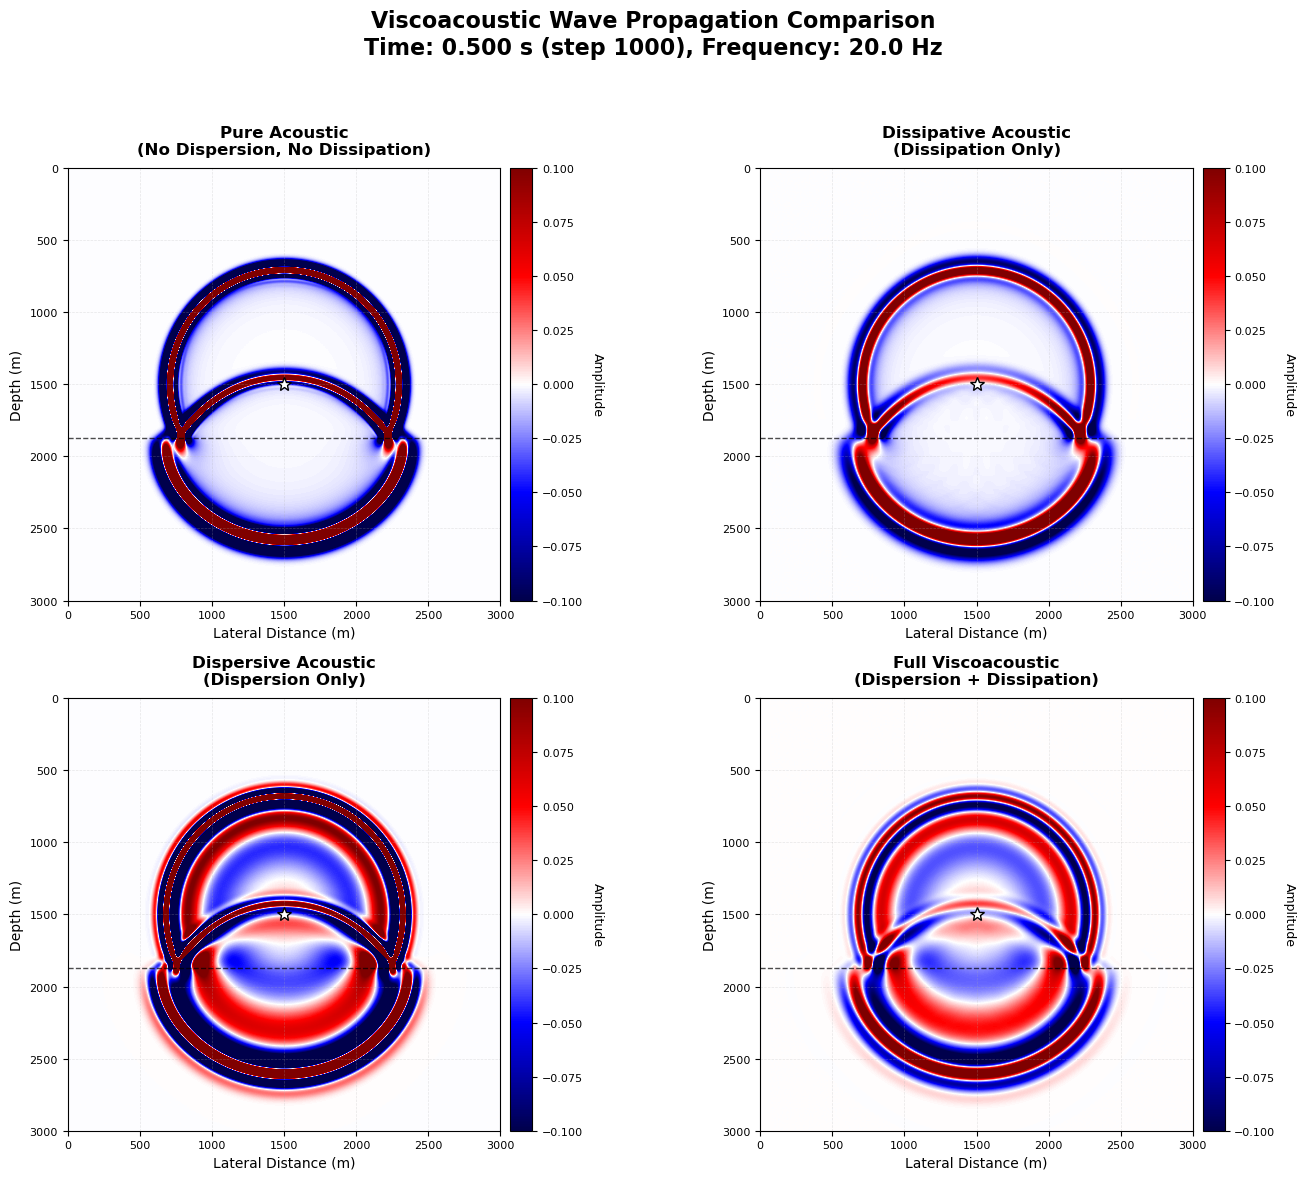


Amplitude Statistics at t = 0.500 s:
  Pure Acoustic:    min= -0.9019, max=  1.5760
  Dissipative:      min= -0.1610, max=  0.3740
  Dispersive:       min= -0.9455, max=  1.2149
  Viscoacoustic:    min= -0.2589, max=  0.1971
Seismogram comparison saved as: Seismogram_Comparison.png


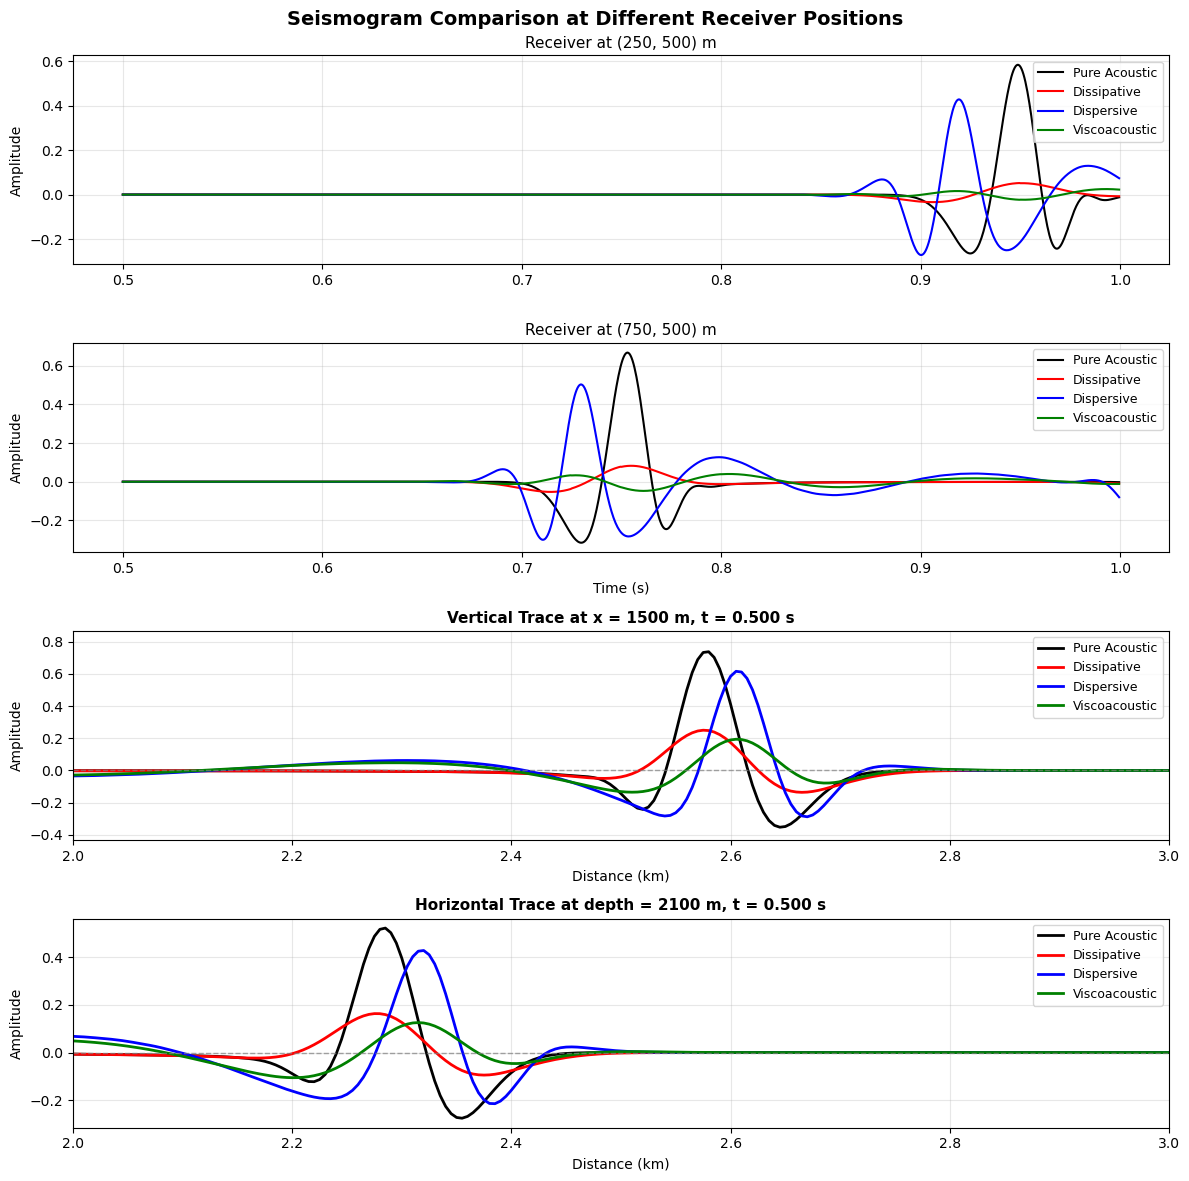

Visualization completed successfully!


In [6]:
def visualize_viscoacoustic_snapshots(U_00, U_01, U_10, U_11, 
                                    simulation_params, 
                                    time_step=150, 
                                    clip_value=None,
                                    save_figure=True,
                                    output_filename="ViscoAcoustic_Snapshot.png"):
    """
    Visualize snapshots of viscoacoustic wave simulation results at a specific time step.
    
    This function creates a 2x2 subplot comparing four different physics scenarios:
    1. Pure acoustic (no dispersion, no dissipation)
    2. Dissipative acoustic (no dispersion, with dissipation) 
    3. Dispersive acoustic (with dispersion, no dissipation)
    4. Full viscoacoustic (with both dispersion and dissipation)
    
    Parameters:
    -----------
    U_00, U_01, U_10, U_11 : numpy.ndarray
        Complex wavefield arrays with shapes (nz, nx, nt) for different physics:
        - U_00: No dispersion, no dissipation
        - U_01: No dispersion, with dissipation
        - U_10: With dispersion, no dissipation  
        - U_11: With dispersion and dissipation
    
    simulation_params : dict
        Dictionary containing simulation parameters:
        - 'nz', 'nx': Grid dimensions
        - 'h': Spatial grid spacing (m)
        - 'dt': Time step (s)
        - 'isz', 'isx': Source position indices
        - 'fp': Peak frequency (Hz)
    
    time_step : int, optional
        Time step index to visualize (default: 150)
    
    clip_value : float, optional
        Amplitude clipping value for display. If None, auto-computed (default: None)
    
    save_figure : bool, optional
        Whether to save the figure (default: True)
    
    output_filename : str, optional
        Output filename for saved figure (default: "ViscoAcoustic_Snapshot.png")
    """
    
    #################################
    # Extract simulation parameters #
    #################################
    nz, nx   = simulation_params.get('nz', 601), simulation_params.get('nx', 601)
    h        = simulation_params.get('h', 5)
    dt       = simulation_params.get('dt', 0.0005) 
    isz, isx = simulation_params.get('isz', 300), simulation_params.get('isx', 300)
    fp       = simulation_params.get('fp', 20.0)    

    ######################
    # Validate time step #
    ######################
    nt = U_00.shape[2]
    if time_step >= nt:
        raise ValueError(f"time_step ({time_step}) must be less than nt ({nt})")
    
    current_time = time_step * dt
    print(f"Visualizing wavefield at time step {time_step} (t = {current_time:.3f} s)")

    ###########################################################
    # Extract real parts of wavefields at specified time step #
    ###########################################################
    wave_00 = np.real(U_00[:, :, time_step])  # Pure acoustic
    wave_01 = np.real(U_01[:, :, time_step])  # Dissipative
    wave_10 = np.real(U_10[:, :, time_step])  # Dispersive  
    wave_11 = np.real(U_11[:, :, time_step])  # Viscoacoustic

    ###############################################
    # Auto-compute clipping value if not provided #
    ###############################################
    if clip_value is None:
        # Use 95th percentile of absolute values for robust clipping
        all_amplitudes = np.concatenate([
            np.abs(wave_00.flatten()),
            np.abs(wave_01.flatten()), 
            np.abs(wave_10.flatten()),
            np.abs(wave_11.flatten())
        ])
        clip_value = np.percentile(all_amplitudes, 95)
        print(f"Auto-computed clipping value: {clip_value:.4f}")
    
    #############################################################
    # Create spatial coordinate arrays for proper axis labeling #
    #############################################################
    z_coords = np.arange(nz) * h  # Depth coordinates (m)
    x_coords = np.arange(nx) * h  # Lateral coordinates (m)
    
    source_z = isz * h  # Source depth (m)
    source_x = isx * h  # Source lateral position (m)
    
    ##################################
    # Create the figure and subplots #
    ##################################
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f'Viscoacoustic Wave Propagation Comparison\n'
                f'Time: {current_time:.3f} s (step {time_step}), '
                f'Frequency: {fp} Hz', 
                fontsize=16, fontweight='bold')
    
    ##################################
    # Define subplot data and titles #
    ##################################
    subplots_data = [
        (wave_00, "Pure Acoustic\n(No Dispersion, No Dissipation)", (0, 0)),
        (wave_01, "Dissipative Acoustic\n(Dissipation Only)", (0, 1)), 
        (wave_10, "Dispersive Acoustic\n(Dispersion Only)", (1, 0)),
        (wave_11, "Full Viscoacoustic\n(Dispersion + Dissipation)", (1, 1))
    ]
    
#     interface_depth = (nz/2) * h
    interface_depth = int(nz/1.6) * h
    
    #####################
    # Plot each subplot #
    #####################
    for wave_data, title, (row, col) in subplots_data:
        ax = axes[row, col]
        
        # Create the image plot with proper extent for physical coordinates
        im = ax.imshow(wave_data, 
                      vmin=-clip_value, vmax=clip_value,
                      cmap='seismic',
                      aspect='equal',
                      extent=[x_coords[0], x_coords[-1], z_coords[-1], z_coords[0]],
                      interpolation='bilinear')
        
        # Add title and labels
        ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
        ax.set_xlabel('Lateral Distance (m)', fontsize=10)
        ax.set_ylabel('Depth (m)', fontsize=10)
        
        # Mark source location
        source_marker = Circle((source_x, source_z), radius=h*2, 
                             color='white', fill=False, linewidth=2)
        ax.add_patch(source_marker)
        ax.plot(source_x, source_z, 'w*', markersize=10, markeredgecolor='black')
        
        # Show velocity interface 
        ax.axhline(y=interface_depth, color='black', linestyle='--',
                  alpha=0.7, linewidth=1.0, label=f'Interface ({interface_depth:.0f}m)')
        
        # # Add colorbar
        # cbar = plt.colorbar(im, ax=ax, shrink=1.0, pad=0.02)
        # cbar.set_label('Amplitude', rotation=270, labelpad=15, fontsize=9)
        # cbar.ax.tick_params(labelsize=8)

        # Or you may use make_axes_locatable for exact alignment
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes("right", size="5%", pad=0.1)  # 5% width, 0.02 pad
        cbar    = plt.colorbar(im, cax=cax)
        cbar.set_label('Amplitude', rotation=270, labelpad=15, fontsize=9)
        cbar.ax.tick_params(labelsize=8)
        
        # Add grid for better readability
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        ax.tick_params(labelsize=8)
    
    ########################################
    # Adjust layout to prevent overlapping #
    ########################################
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    
    ##############################################
    # Save figure with high quality if requested #
    ##############################################
    if save_figure:
        plt.savefig(output_filename, format="png", dpi=600, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
        print(f"Figure saved as: {output_filename}")
    
    ####################
    # Display the plot #
    ####################
    plt.show()
    
    ##############################
    # Print amplitude statistics #
    ##############################
    print(f"\nAmplitude Statistics at t = {current_time:.3f} s:")
    print(f"  Pure Acoustic:    min={np.min(wave_00):8.4f}, max={np.max(wave_00):8.4f}")
    print(f"  Dissipative:      min={np.min(wave_01):8.4f}, max={np.max(wave_01):8.4f}")
    print(f"  Dispersive:       min={np.min(wave_10):8.4f}, max={np.max(wave_10):8.4f}")
    print(f"  Viscoacoustic:    min={np.min(wave_11):8.4f}, max={np.max(wave_11):8.4f}")

def create_time_evolution_plot(U_list, labels, simulation_params, 
                             receiver_positions=None,
                             time_range=None, snapshot_time=None,
                             save_figure=True):
    """
    Create time evolution plots showing seismograms at specific receiver locations.
    
    Parameters:
    -----------
    U_list : list of numpy.ndarray
        List of wavefield arrays to compare
    labels : list of str
        Labels for each wavefield
    simulation_params : dict
        Simulation parameters dictionary
    receiver_positions : list of tuples, optional
        List of (iz, ix) receiver positions. If None, uses default positions
    time_range : tuple, optional
        (start_time, end_time) in seconds. If None, shows full time range
    save_figure : bool, optional
        Whether to save the figure
    """

    # Extract parameters
    dt = simulation_params.get('dt', 0.0005)
    nt = U_list[0].shape[2]
    h  = simulation_params.get('h', 5)
    nz = simulation_params.get('nz', 601)
    nx = simulation_params.get('nx', 601)
    
    # Set default receiver positions if not provided
    if receiver_positions is None:
        receiver_positions = [
            (nz//4, nx//2),      # Shallow receiver
#             (nz//2, nx//2),      # Middle receiver  
            (3*nz//4, nx//2)     # Deep receiver
        ]
    
    # Create time axis
    time_axis = np.arange(nt) * dt
    
    # Apply time range filter if specified
    if time_range is not None:
        start_idx = int(time_range[0] / dt)
        end_idx   = int(time_range[1] / dt)
        time_axis = time_axis[start_idx:end_idx]
    else:
        start_idx, end_idx = 0, nt
    
    # Determine snapshot time index
    if snapshot_time is None:
        snapshot_idx = nt // 2
    else:
        snapshot_idx = int(snapshot_time / dt)
    
    # Create subplots for each receiver
    fig, axes = plt.subplots(4, 1, figsize=(12, 12))
    axes      = np.array(axes).flatten()
    
    fig.suptitle('Seismogram Comparison at Different Receiver Positions', 
                fontsize=14, fontweight='bold')

    # Colors matching the screenshot
    colors = ['black', 'red', 'blue', 'green']
     
    ##################################################
    # Plot time-series seismograms for each receiver # 
    ##################################################
    for i, (iz, ix) in enumerate(receiver_positions):
        ax = axes[i]
        
        # Plot seismograms for each physics scenario
        for j, (U, label) in enumerate(zip(U_list, labels)):
            seismogram = np.real(U[iz, ix, start_idx:end_idx])
            ax.plot(time_axis, seismogram, 
                   color=colors[j % len(colors)], 
                   linewidth=1.5, 
                   label=label)
        
        # Formatting
        ax.set_ylabel('Amplitude', fontsize=10)
        ax.set_title(f'Receiver at ({iz*h:.0f}, {ix*h:.0f}) m', fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9, loc='upper right')
        
        # enforce time range
#         if time_range is not None:
#             ax.set_xlim(time_range[0], time_range[1])
#         else:
#             ax.set_xlim(time_axis[0], time_axis[-1])
        
        # Only add x-label to second-to-last plot
        if i == len(receiver_positions) - 1:
            ax.set_xlabel('Time (s)', fontsize=10)
    
    # Uncomment to show just the pure acoustic and viscoacoustic traces.
#     U_list = [U_00, U_11]
#     labels = [ 'Pure Acoustic', 'Viscoacoustic' ]
    
    ##############################################################
    # Third subplot: Distance vs Amplitude at specific time step #
    ##############################################################
#     ix_profile  = nz // 2
    ix_profile  = 1500 // h
    distance_km = np.arange(nx) * h / 1000.0  # Convert to km
    
    ax_vertical = axes[-2]
    # Plot amplitude profiles at snapshot time
    for j, (U, label) in enumerate(zip(U_list, labels)):
        amplitude_profile = np.real(U[:, ix_profile, snapshot_idx])
        ax_vertical.plot(distance_km, amplitude_profile,
                        color=colors[j % len(colors)],
                        linewidth=2,
                        label=label)
    
    # Formatting for distance plot
    ax_vertical.set_xlabel('Distance (km)', fontsize=10)
    ax_vertical.set_xlim(2., 3.)
    ax_vertical.set_ylabel('Amplitude', fontsize=10)
    ax_vertical.set_title(f'Vertical Trace at x = {ix_profile*h:.0f} m, t = {snapshot_idx*dt:.3f} s', fontsize=11, fontweight='bold')
    ax_vertical.grid(True, alpha=0.3)
    ax_vertical.legend(fontsize=9, loc='upper right')
    ax_vertical.axhline(y=0, color='gray', linestyle='--', linewidth=1.0, alpha=0.7)
    
    ###############################################################
    # Fourth subplot: Distance vs Amplitude at specific time step #
    ###############################################################

    # Create distance array along horizontal line (middle depth)
    iz_profile  = 2100 // h
    distance_km = np.arange(nx) * h / 1000.0  # Convert to km
    
    ax_horizontal = axes[-1]
    # Plot amplitude profiles at snapshot time
    for j, (U, label) in enumerate(zip(U_list, labels)):
        amplitude_profile = np.real(U[iz_profile, :, snapshot_idx])
        ax_horizontal.plot(distance_km, amplitude_profile,
                        color=colors[j % len(colors)],
                        linewidth=2,
                        label=label)
    
    # Formatting for distance plot
    ax_horizontal.set_xlabel('Distance (km)', fontsize=10)
    ax_horizontal.set_xlim(2, 3.)
    ax_horizontal.set_ylabel('Amplitude', fontsize=10)
    ax_horizontal.set_title(f'Horizontal Trace at depth = {iz_profile*h:.0f} m, t = {snapshot_idx*dt:.3f} s', fontsize=11, fontweight='bold')
    ax_horizontal.grid(True, alpha=0.3)
    ax_horizontal.legend(fontsize=9, loc='upper right')
    ax_horizontal.axhline(y=0, color='gray', linestyle='--', linewidth=1.0, alpha=0.7)
    
    plt.tight_layout()
    
    if save_figure:
        plt.savefig('Seismogram_Comparison.png', dpi=600, bbox_inches='tight')
        print("Seismogram comparison saved as: Seismogram_Comparison.png")
    
    plt.show()
    
#############################################
# Example usage with the simulation results #
#############################################
if __name__ == "__main__":
    
    # Assuming U_00, U_01, U_10, U_11 are already computed from the simulation
    
    # Define simulation parameters (should match your simulation setup)
    sim_params = {
        'nz': 601, 'nx': 601,    # Grid dimensions
        'h': 5,                  # Grid spacing (m)
        'dt': 0.0005,            # Time step (s)
        'isz': 300, 'isx': 300,  # Source position
        'fp': 20.0               # Peak frequency (Hz)
    }
    
    print("Creating viscoacoustic wave propagation visualization...")

    ####################################################
    # Create snapshot comparison at specific time step #
    ####################################################
    visualize_viscoacoustic_snapshots(
        U_00, U_01, U_10, U_11,
        simulation_params=sim_params,
        time_step=1000,          # Time step to visualize  
        clip_value=0.1,         # Amplitude clipping value
        save_figure=True,
        output_filename="ViscoAcoustic_Snapshot.png" )
    
    ################################
    # Create seismogram comparison #
    ################################
    wavefield_list = [U_00, U_01, U_10, U_11]
    physics_labels = [
        'Pure Acoustic',
        'Dissipative', 
        'Dispersive',
        'Viscoacoustic' ]
    
    create_time_evolution_plot(
        wavefield_list, 
        physics_labels,
        sim_params,
        receiver_positions=[(50, 100), (150, 100)],
        time_range=(0.5, 1.0), snapshot_time=0.5,
        save_figure=True )
    
    print("Visualization completed successfully!")


### Combined Viscoacoustic Visualization

Creating enhanced combined viscoacoustic visualization...
Creating combined visualization at t = 0.500 s (step 1000)
Initialized with Pure Acoustic wavefield (shape: (601, 601))
Quadrants filled with respective physics scenarios
Combined visualization saved as: Combined_ViscoAcoustic.png


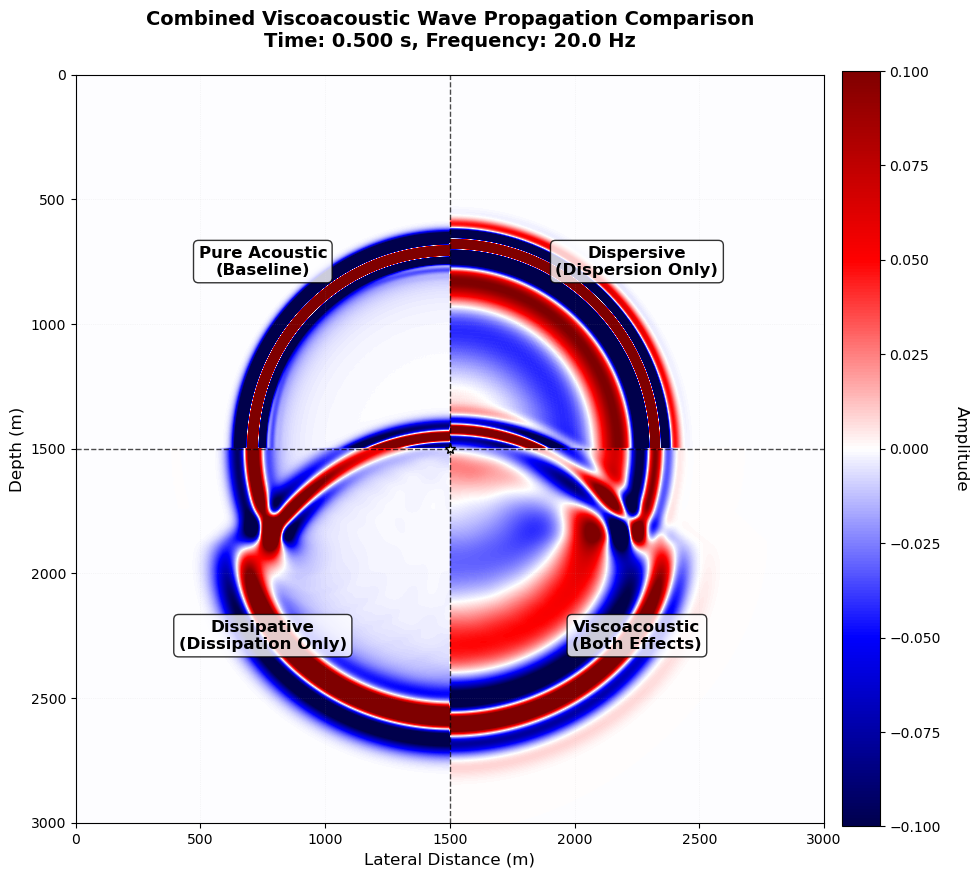


Quadrant Amplitude Statistics:
  Top-Left (Pure):        min= -0.4202, max=  0.8428
  Top-Right (Dispersive): min= -0.3743, max=  0.6558
  Bottom-Left (Dissip.):  min= -0.1610, max=  0.3740
  Bottom-Right (Visco.):  min= -0.2589, max=  0.1971

Creating physics effects analysis...
Effects analysis saved as: Viscoacoustic_Effects_Analysis.png


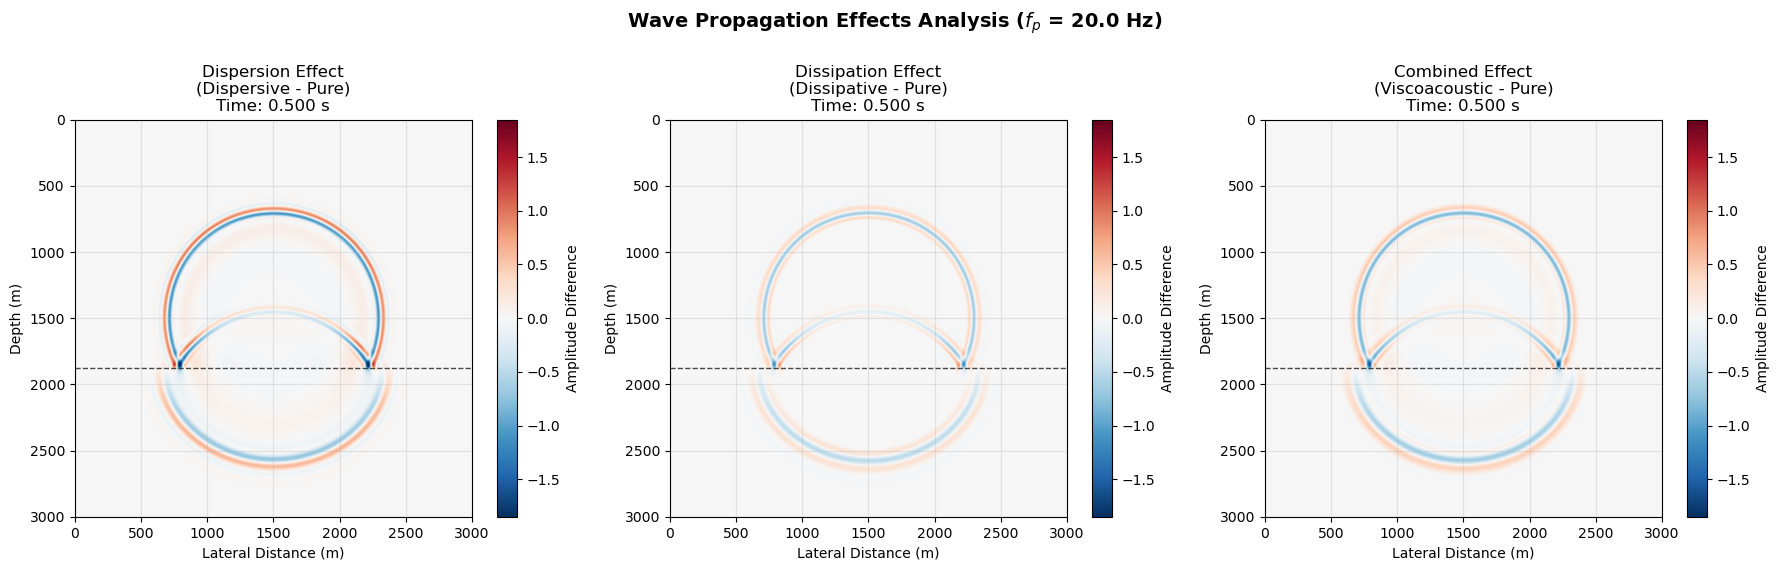

All visualizations completed successfully!


In [7]:
def create_combined_viscoacoustic_visualization(U_00, U_01, U_10, U_11, 
                                              simulation_params,
                                              time_step=150, 
                                              clip_value=0.1,
                                              save_figure=True,
                                              output_filename="Combined_ViscoAcoustic.png"):
    """
    Create a combined visualization showing all four physics scenarios in quadrants.
    
    This function creates a single figure divided into four quadrants, each showing
    a different combination of dispersion and dissipation effects:
    
    +---------------------+------------------+
    |   Pure Acoustic     |   Dispersive     |
    | (No Disp, No Diss)  | (Disp, No Diss)  |
    +---------------------+------------------+
    |   Dissipative       |  Viscoacoustic   |
    | (No Disp, Diss)     | (Disp + Diss)    |
    +---------------------+------------------+
    
    Parameters:
    -----------
    U_00, U_01, U_10, U_11 : numpy.ndarray
        Complex wavefield arrays (nz, nx, nt) for different physics scenarios
    simulation_params : dict
        Dictionary containing simulation parameters
    time_step : int
        Time step to visualize
    clip_value : float
        Amplitude clipping value for display
    save_figure : bool
        Whether to save the figure
    output_filename : str
        Output filename for saved figure
    
    Returns:
    --------
    numpy.ndarray : The combined visualization array
    """
    
    #################################
    # Extract simulation parameters #
    #################################
    nz  = simulation_params.get('nz', 601)
    nx  = simulation_params.get('nx', 601) 
    h   = simulation_params.get('h', 5)
    dt  = simulation_params.get('dt', 0.0005)
    isz = simulation_params.get('isz', 300)
    isx = simulation_params.get('isx', 300)
    fp  = simulation_params.get('fp', 20.0)
    
    ###################
    # Validate inputs #
    ###################
    if time_step >= U_00.shape[2]:
        raise ValueError(f"time_step ({time_step}) exceeds available time steps ({U_00.shape[2]})")
    
    current_time = time_step * dt
    print(f"Creating combined visualization at t = {current_time:.3f} s (step {time_step})")
    
    ########################################################################
    # Initialize the combined array with the pure acoustic case (baseline) #
    ########################################################################
    combined = np.real(U_00[:, :, time_step]).copy()
    print(f"Initialized with Pure Acoustic wavefield (shape: {combined.shape})")

    #######################################################
    # Fill each quadrant with different physics scenarios #
    #######################################################
    # The combined visualization is structured as:
    # Top-left:     Pure Acoustic    (U_00) - already filled
    # Top-right:    Dispersive       (U_10) - dispersion only
    # Bottom-left:  Dissipative      (U_01) - dissipation only  
    # Bottom-right: Viscoacoustic    (U_11) - both effects
    
    # Top-right quadrant: Dispersive acoustic (dispersion only)
    combined[:, nx // 2:nx] = np.real(U_10[:, nx // 2:nx, time_step])
    
    # Bottom-left quadrant: Dissipative acoustic (dissipation only)
    combined[nz // 2:nz, :nx // 2] = np.real(U_01[nz // 2:nz, :nx // 2, time_step])
    
    # Bottom-right quadrant: Full viscoacoustic (dispersion + dissipation)
    combined[nz // 2:nz, nx // 2:nx] = np.real(U_11[nz // 2:nz, nx // 2:nx, time_step])
    
    print("Quadrants filled with respective physics scenarios")
    
    # Create the visualization
    #########################
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Create spatial coordinate arrays for proper axis labeling
    z_coords = np.arange(nz) * h
    x_coords = np.arange(nx) * h
    
    # Display the combined image
    im = ax.imshow(combined, 
                   vmin=-clip_value, vmax=clip_value,
                   cmap='seismic',
                   aspect='equal',
                   extent=[x_coords[0], x_coords[-1], z_coords[-1], z_coords[0]],
                   interpolation='bilinear')
    
    ###########################################
    # Add quadrant boundary lines for clarity #
    ###########################################
    mid_x = (nx // 2) * h  # Middle x-coordinate in physical units
    mid_z = (nz // 2) * h  # Middle z-coordinate in physical units
    
    # Vertical line separating left and right quadrants
    ax.axvline(x=mid_x, color='black', linewidth=1.0, alpha=0.7, linestyle='--')
    # Horizontal line separating top and bottom quadrants  
    ax.axhline(y=mid_z, color='black', linewidth=1.0, alpha=0.7, linestyle='--')
    
    # Add quadrant labels with background boxes for better visibility
    ###############################################################
    label_style = dict(bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
                      fontsize=12, fontweight='bold', ha='center', va='center')
    
    # Calculate label positions (centers of each quadrant)
    label_x1, label_x2 = mid_x / 2, mid_x + (x_coords[-1] - mid_x) / 2
    label_z1, label_z2 = mid_z / 2, mid_z + (z_coords[-1] - mid_z) / 2
    
    # Place labels in each quadrant
    ax.text(label_x1, label_z1, 'Pure Acoustic\n(Baseline)', **label_style)
    ax.text(label_x2, label_z1, 'Dispersive\n(Dispersion Only)', **label_style)
    ax.text(label_x1, label_z2, 'Dissipative\n(Dissipation Only)', **label_style)
    ax.text(label_x2, label_z2, 'Viscoacoustic\n(Both Effects)', **label_style)
   
    ##########################################
    # Mark source locations in each quadrant #
    ##########################################
    source_z = isz * h
    source_x = isx * h
    
    # Source markers for each quadrant (adjusted positions)
    source_positions = [
        (source_x if source_x < mid_x else source_x - mid_x, 
         source_z if source_z < mid_z else source_z - mid_z),  # Top-left
        (source_x if source_x >= mid_x else source_x + mid_x, 
         source_z if source_z < mid_z else source_z - mid_z),  # Top-right
        (source_x if source_x < mid_x else source_x - mid_x, 
         source_z if source_z >= mid_z else source_z + mid_z), # Bottom-left
        (source_x if source_x >= mid_x else source_x + mid_x, 
         source_z if source_z >= mid_z else source_z + mid_z)  # Bottom-right
    ]
    
    # Add source markers
    for src_x, src_z in [(source_x, source_z)]:  # Original source position
        # Add markers in all four quadrants to show relative positions
        ax.plot(src_x, src_z, 'w*', markersize=8, markeredgecolor='black', markeredgewidth=1)
        if src_x < mid_x and src_z < mid_z:  # Source is in top-left
            ax.plot(src_x + mid_x, src_z, 'w*', markersize=8, markeredgecolor='black', markeredgewidth=1)  # Top-right
            ax.plot(src_x, src_z + mid_z, 'w*', markersize=8, markeredgecolor='black', markeredgewidth=1)  # Bottom-left
            ax.plot(src_x + mid_x, src_z + mid_z, 'w*', markersize=8, markeredgecolor='black', markeredgewidth=1)  # Bottom-right
    
    #########################
    # Formatting and labels #
    #########################
    ax.set_title(f'Combined Viscoacoustic Wave Propagation Comparison\n'
                f'Time: {current_time:.3f} s, Frequency: {fp} Hz', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Lateral Distance (m)', fontsize=12)
    ax.set_ylabel('Depth (m)', fontsize=12)
    
    # Add colorbar with proper formatting
    cbar = plt.colorbar(im, ax=ax, shrink=0.78, pad=0.02)
    cbar.set_label('Amplitude', rotation=270, labelpad=20, fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    
    # Add grid for better spatial reference
    ax.grid(True, alpha=0.2, linestyle=':', linewidth=0.5)
    ax.tick_params(labelsize=10)

    #######################################
    # Add legend explaining the quadrants #
    #######################################
    # legend_elements = [
    #     mlines.Line2D([0], [0], marker='s', color='lightblue', label='Pure Acoustic (Top-Left)',
    #                  markersize=10, linestyle='None', markeredgecolor='black'),
    #     mlines.Line2D([0], [0], marker='s', color='lightgreen', label='Dispersive (Top-Right)',
    #                  markersize=10, linestyle='None', markeredgecolor='black'),
    #     mlines.Line2D([0], [0], marker='s', color='lightyellow', label='Dissipative (Bottom-Left)',
    #                  markersize=10, linestyle='None', markeredgecolor='black'),
    #     mlines.Line2D([0], [0], marker='s', color='lightcoral', label='Viscoacoustic (Bottom-Right)',
    #                  markersize=10, linestyle='None', markeredgecolor='black'),
    #     mlines.Line2D([0], [0], marker='*', color='white', label='Source Location',
    #                  markersize=10, linestyle='None', markeredgecolor='black')
    # ]
    
    # ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1),
    #          fontsize=10, framealpha=0.9)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()

    ############################ 
    # Save figure if requested #
    ############################
    if save_figure:
        plt.savefig(output_filename, format="png", dpi=600, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
        print(f"Combined visualization saved as: {output_filename}")
    
    # Display the plot
    plt.show()

    ######################################
    # Print statistics for each quadrant #
    ######################################
    print(f"\nQuadrant Amplitude Statistics:")
    print(f"  Top-Left (Pure):        min={np.min(combined[:nz//2, :nx//2]):8.4f}, "
          f"max={np.max(combined[:nz//2, :nx//2]):8.4f}")
    print(f"  Top-Right (Dispersive): min={np.min(combined[:nz//2, nx//2:]):8.4f}, "
          f"max={np.max(combined[:nz//2, nx//2:]):8.4f}")
    print(f"  Bottom-Left (Dissip.):  min={np.min(combined[nz//2:, :nx//2]):8.4f}, "
          f"max={np.max(combined[nz//2:, :nx//2]):8.4f}")
    print(f"  Bottom-Right (Visco.):  min={np.min(combined[nz//2:, nx//2:]):8.4f}, "
          f"max={np.max(combined[nz//2:, nx//2:]):8.4f}")
    
    return combined


def create_difference_visualization(U_00, U_01, U_10, U_11, 
                                  simulation_params,
                                  time_step=150,
                                  save_figure=True):
    """
    Create difference visualizations showing the effects of dispersion and dissipation.
    
    This function creates three difference plots:
    1. Dispersion effect: U_10 - U_00 (dispersive minus pure acoustic)
    2. Dissipation effect: U_01 - U_00 (dissipative minus pure acoustic)  
    3. Combined effect: U_11 - U_00 (viscoacoustic minus pure acoustic)
    """
    
    # Extract parameters
    dt = simulation_params.get('dt', 0.0005)
    fp = simulation_params.get('fp', 20.0)
    current_time = time_step * dt
    
    # Compute differences
    diff_dispersion  = np.real(U_10[:, :, time_step]) - np.real(U_00[:, :, time_step])
    diff_dissipation = np.real(U_01[:, :, time_step]) - np.real(U_00[:, :, time_step])
    diff_combined    = np.real(U_11[:, :, time_step]) - np.real(U_00[:, :, time_step])
    
    # Create subplot figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    differences = [diff_dispersion, diff_dissipation, diff_combined]
    titles = ['Dispersion Effect\n(Dispersive - Pure)', 
             'Dissipation Effect\n(Dissipative - Pure)',
             'Combined Effect\n(Viscoacoustic - Pure)']
    
    # Compute symmetric clipping based on all differences
    max_diff  = np.max([np.abs(diff).max() for diff in differences])
    clip_diff = max_diff * 0.8  # Use 80% of maximum for better contrast

    # Create spatial coordinate arrays for proper axis labeling
    z_coords = np.arange(nz) * h
    x_coords = np.arange(nx) * h
    
    interface_depth = int(nz/1.6) * h
      
    for i, (diff, title) in enumerate(zip(differences, titles)):
        im = axes[i].imshow(diff, vmin=-clip_diff, vmax=clip_diff, 
                           cmap='RdBu_r', aspect='equal', extent=[x_coords[0], x_coords[-1], z_coords[-1], z_coords[0]],)
        axes[i].set_title(f'{title}\nTime: {current_time:.3f} s', fontsize=12)
        axes[i].set_xlabel('Lateral Distance (m)')
        axes[i].set_ylabel('Depth (m)')
        
        # Show velocity interface 
        axes[i].axhline(y=interface_depth, color='black', linestyle='--',
                      alpha=0.7, linewidth=1.0, label=f'Interface ({interface_depth:.0f}m)')  
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[i], shrink=0.75)
        cbar.set_label('Amplitude Difference')
        
        # Add grid
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle(f'Wave Propagation Effects Analysis ($f_p$ = {fp} Hz)', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_figure:
        plt.savefig('Viscoacoustic_Effects_Analysis.png', dpi=600, bbox_inches='tight')
        print("Effects analysis saved as: Viscoacoustic_Effects_Analysis.png")
    
    plt.show()


#################
# Example usage #
#################
if __name__ == "__main__":
    # Assuming simulation results are available
    # Define simulation parameters
    sim_params = {
        'nz': 601, 'nx': 601,
        'h': 5, 'dt': 0.0005,
        'isz': 300, 'isx': 300,
        'fp': 20.0
    }
    
    # Create combined visualization
    print("Creating enhanced combined viscoacoustic visualization...")
    
    combined_result = create_combined_viscoacoustic_visualization(
        U_00, U_01, U_10, U_11,
        simulation_params=sim_params,
        time_step=1000,
        clip_value=0.1,
        save_figure=True,
        output_filename="Combined_ViscoAcoustic.png"
    )
    
    # Create difference analysis
    print("\nCreating physics effects analysis...")
    create_difference_visualization(
        U_00, U_01, U_10, U_11,
        simulation_params=sim_params,
        time_step=1000,
        save_figure=True
    )
    
    print("All visualizations completed successfully!")
    

### Animated comparison of viscoacoustic wave propagation scenarios

CREATING ANIMATED VISCOACOUSTIC VISUALIZATIONS

1. Creating 2x2 comparison animation...
Creating animation with 48 frames
Time range: 0.025 to 0.500 seconds
Frame skip: 20 (showing every 20 time steps)
Generating animation frames...
Saving animation as viscoacoustic_animation.gif...
Animation saved successfully as viscoacoustic_animation.gif

2. Creating combined quadrant animation...
Creating combined quadrant animation with 48 frames
Combined animation saved as: combined_viscoacoustic_animation.gif

ANIMATION CREATION COMPLETED

To display animations in Jupyter notebook:
  from IPython.display import HTML
  HTML(anim1.to_jshtml())


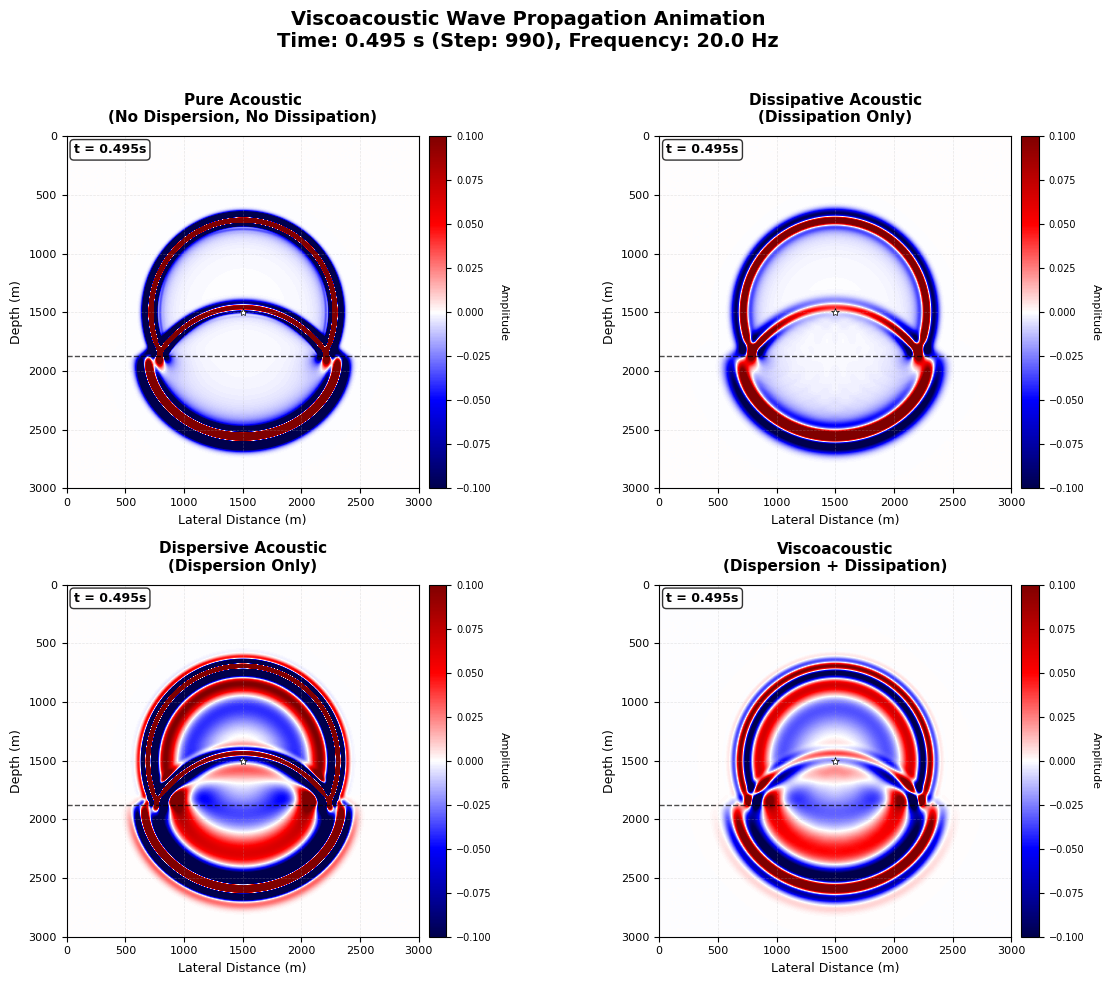

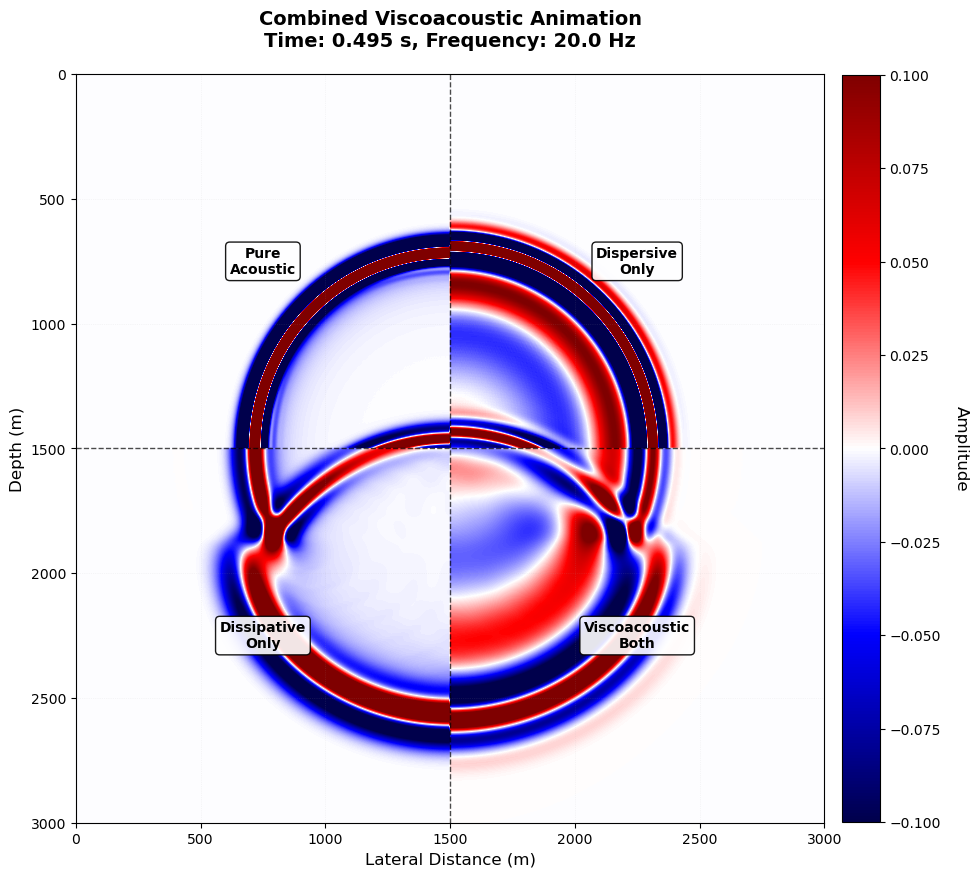

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle
import matplotlib.patches as patches
from IPython.display import HTML
from PIL import Image

def create_animated_viscoacoustic_comparison(U_00, U_01, U_10, U_11, 
                                           simulation_params,
                                           time_range=None,
                                           clip_value=0.1,
                                           frame_skip=5,
                                           animation_speed=50,
                                           save_animation=True,
                                           output_filename="viscoacoustic_animation.gif"):
    """
    Create an animated comparison of viscoacoustic wave propagation scenarios.
    
    This function generates a 2x2 subplot animation showing four different physics
    scenarios evolving over time, allowing visualization of wave propagation
    differences due to dispersion and dissipation effects.
    
    Parameters:
    -----------
    U_00, U_01, U_10, U_11 : numpy.ndarray
        Complex wavefield arrays (nz, nx, nt) for different physics scenarios:
        - U_00: Pure acoustic (no dispersion, no dissipation)
        - U_01: Dissipative (no dispersion, with dissipation)
        - U_10: Dispersive  (with dispersion, no dissipation)
        - U_11: Viscoacoustic (with dispersion and dissipation)
    
    simulation_params : dict
        Dictionary containing simulation parameters
    
    time_range : tuple, optional
        (start_step, end_step) for animation range. If None, uses full time range
    
    clip_value : float
        Amplitude clipping value for consistent color scaling
    
    frame_skip : int
        Skip frames for faster animation (every nth frame)
    
    animation_speed : int
        Animation speed in milliseconds between frames
    
    save_animation : bool
        Whether to save the animation as GIF
    
    output_filename : str
        Output filename for saved animation
    
    Returns:
    --------
    matplotlib.animation.FuncAnimation : The animation object
    """
    
    #################################
    # Extract simulation parameters #
    #################################
    nz  = simulation_params.get('nz', 601)
    nx  = simulation_params.get('nx', 601) 
    h   = simulation_params.get('h', 5)
    dt  = simulation_params.get('dt', 0.0005)
    isz = simulation_params.get('isz', 300)
    isx = simulation_params.get('isx', 300)
    fp  = simulation_params.get('fp', 20.0)

    ######################################
    # Determine time range for animation #
    ######################################
    nt = U_00.shape[2]
    if time_range is None:
        start_frame, end_frame = 1, nt - 1  # Skip first and last frames
    else:
        start_frame, end_frame = time_range
        # start_frame = max(1, start_frame)
        # end_frame  = min(nt - 1, end_frame)
    
    # Create frame indices with skipping
    frame_indices = range(start_frame, end_frame, frame_skip)
    total_frames = len(frame_indices)
    
    print(f"Creating animation with {total_frames} frames")
    print(f"Time range: {start_frame * dt:.3f} to {end_frame * dt:.3f} seconds")
    print(f"Frame skip: {frame_skip} (showing every {frame_skip} time steps)")

    ##################################
    # Set up the figure and subplots #
    ##################################
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Viscoacoustic Wave Propagation Animation', fontsize=16, fontweight='bold')
    
    # Create coordinate arrays for proper axis labeling
    z_coords = np.arange(nz) * h
    x_coords = np.arange(nx) * h
    
    # Source position in physical coordinates
    source_z, source_x = isz * h, isx * h

    #############################################
    # Initialize image objects for each subplot #
    #############################################
    wavefield_data = [U_00, U_01, U_10, U_11]
    subplot_titles = [
        'Pure Acoustic\n(No Dispersion, No Dissipation)',
        'Dissipative Acoustic\n(Dissipation Only)', 
        'Dispersive Acoustic\n(Dispersion Only)',
        'Viscoacoustic\n(Dispersion + Dissipation)'
    ]
    
    images         = []
    source_markers = []
    time_texts     = []
    
#     interface_depth = (nz//2) * h
    interface_depth = int(nz/1.6) * h
    
    # Set up each subplot
    for i, (ax, title) in enumerate(zip(axes.flat, subplot_titles)):
        # Initialize with first frame
        initial_data = np.real(wavefield_data[i][:, :, start_frame])
        
        im = ax.imshow(initial_data,
                      vmin=-clip_value, vmax=clip_value,
                      cmap='seismic',
                      aspect='equal',
                      extent=[x_coords[0], x_coords[-1], z_coords[-1], z_coords[0]],
                      interpolation='bilinear')
        
        images.append(im)
        
        # Set up subplot formatting
        ax.set_title(title, fontsize=11, fontweight='bold', pad=10)
        ax.set_xlabel('Lateral Distance (m)', fontsize=9)
        ax.set_ylabel('Depth (m)', fontsize=9)
        ax.axhline(y=interface_depth, color='black', linestyle='--', alpha=0.7, linewidth=1.0) 
        ax.tick_params(labelsize=8)
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        
        # Add source marker
        source_circle = Circle((source_x, source_z), radius=h*2, 
                             color='white', fill=False, linewidth=1.5)
        ax.add_patch(source_circle)
        source_star = ax.plot(source_x, source_z, 'w*', markersize=6, 
                             markeredgecolor='black', markeredgewidth=0.5)[0]
        source_markers.append(source_star)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=1.0, pad=0.02)
        cbar.set_label('Amplitude', rotation=270, labelpad=12, fontsize=8)
        cbar.ax.tick_params(labelsize=7)
        
        # Add time text in each subplot
        time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, 
                           fontsize=9, fontweight='bold', 
                           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
                           verticalalignment='top')
        time_texts.append(time_text)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle

    #############################
    # Animation update function #
    #############################
    def animate(frame_idx):
        """Update function for animation frames."""
        current_frame = frame_indices[frame_idx]
        current_time  = current_frame * dt
        
        # Update the main title with current time
        fig.suptitle(f'Viscoacoustic Wave Propagation Animation\n'
                    f'Time: {current_time:.3f} s (Step: {current_frame}), '
                    f'Frequency: {fp} Hz', 
                    fontsize=14, fontweight='bold')
        
        # Update each subplot
        for i, (im, wavefield, time_text) in enumerate(zip(images, wavefield_data, time_texts)):
            # Get current wavefield data
            current_data = np.real(wavefield[:, :, current_frame])
            
            # Update image
            im.set_array(current_data)
            
            # Update time text
            time_text.set_text(f't = {current_time:.3f}s')
        
        return images + time_texts

    ####################
    # Create animation #
    ####################
    print("Generating animation frames...")
    anim = animation.FuncAnimation(fig, animate, frames=total_frames,
                                  interval=animation_speed, blit=False, repeat=True)

    ###############################
    # Save animation if requested #
    ###############################
    if save_animation:
        if not output_filename:
            raise ValueError("Please provide a valid output_filename to save the animation.")
        print(f"Saving animation as {output_filename}...")
        
        try:
            # Try to save as GIF (requires Pillow or imageio)
            anim.save(output_filename, writer='pillow', fps=5, dpi=600)
            print(f"Animation saved successfully as {output_filename}")
        except Exception as e:
            print(f"Could not save as GIF: {e}")
            try:
                # Fallback to MP4 (requires ffmpeg)
                mp4_filename = output_filename.replace('.gif', '.mp4')
                anim.save(mp4_filename, writer='ffmpeg', fps=5, dpi=600)
                print(f"Animation saved as MP4: {mp4_filename}")
            except Exception as e2:
                print(f"Could not save animation: {e2}")
                print("Install 'pillow' for GIF or 'ffmpeg' for MP4 support")
    
    return anim

def create_combined_quadrant_animation(U_00, U_01, U_10, U_11, 
                                     simulation_params,
                                     time_range=None,
                                     clip_value=0.1,
                                     frame_skip=5,
                                     animation_speed=50,
                                     save_animation=True):
    """
    Create an animated combined quadrant visualization.
    
    This creates a single animated plot where each quadrant shows a different
    physics scenario, similar to the static combined visualization but animated.
    """
    
    # Extract parameters
    nz = simulation_params.get('nz', 601)
    nx = simulation_params.get('nx', 601)
    h  = simulation_params.get('h', 5)
    dt = simulation_params.get('dt', 0.0005)
    fp = simulation_params.get('fp', 20.0)
    
    
    # Determine time range
    nt = U_00.shape[2]
    if time_range is None:
        start_frame, end_frame = 1, nt - 1
    else:
        start_frame, end_frame = time_range
    
    frame_indices = range(start_frame, end_frame, frame_skip)
    total_frames  = len(frame_indices)
    
    print(f"Creating combined quadrant animation with {total_frames} frames")
    
    # Set up figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Create coordinate arrays
    z_coords = np.arange(nz) * h
    x_coords = np.arange(nx) * h
    
    # Initialize combined array with first frame
    def create_combined_frame(frame_idx):
        """Create combined quadrant array for given frame."""
        combined = np.real(U_00[:, :, frame_idx]).copy()
        
        # Fill quadrants
        combined[:, nx // 2:nx]          = np.real(U_10[:, nx // 2:nx, frame_idx])           # Top-right: Dispersive
        combined[nz // 2:nz, :nx // 2]   = np.real(U_01[nz // 2:nz, :nx // 2, frame_idx])    # Bottom-left: Dissipative
        combined[nz // 2:nz, nx // 2:nx] = np.real(U_11[nz // 2:nz, nx // 2:nx, frame_idx])  # Bottom-right: Viscoacoustic
        
        return combined
    
    # Initialize image
    initial_combined = create_combined_frame(start_frame)
    im = ax.imshow(initial_combined,
                   vmin=-clip_value, vmax=clip_value,
                   cmap='seismic',
                   aspect='equal',
                   extent=[x_coords[0], x_coords[-1], z_coords[-1], z_coords[0]],
                   interpolation='bilinear')
    
    # Add quadrant boundaries
    mid_x, mid_z = (nx // 2) * h, (nz // 2) * h
    # ax.axvline(x=mid_x, color='black', linewidth=1, alpha=0.7)
    # ax.axhline(y=mid_z, color='black', linewidth=1, alpha=0.7)

    ax.axvline(x=mid_x, color='black', linewidth=1, alpha=0.7,linestyle='--')
    ax.axhline(y=mid_z, color='black', linewidth=1, alpha=0.7,linestyle='--')
    
    # Add quadrant labels
    label_style = dict(bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9),
                      fontsize=10, fontweight='bold', ha='center', va='center')
    
    label_x1, label_x2 = mid_x / 2, mid_x + (x_coords[-1] - mid_x) / 2
    label_z1, label_z2 = mid_z / 2, mid_z + (z_coords[-1] - mid_z) / 2
    
    ax.text(label_x1, label_z1, 'Pure\nAcoustic', **label_style)
    ax.text(label_x2, label_z1, 'Dispersive\nOnly', **label_style)
    ax.text(label_x1, label_z2, 'Dissipative\nOnly', **label_style)
    ax.text(label_x2, label_z2, 'Viscoacoustic\nBoth', **label_style)
    
    # Formatting
    ax.set_xlabel('Lateral Distance (m)', fontsize=12)
    ax.set_ylabel('Depth (m)', fontsize=12)
    ax.grid(True, alpha=0.2, linestyle=':', linewidth=0.5)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.77, pad=0.02)
    cbar.set_label('Amplitude', rotation=270, labelpad=20, fontsize=12)
    
    # Animation function
    def animate_combined(frame_idx):
        current_frame = frame_indices[frame_idx]
        current_time = current_frame * dt
        
        # Update title
        ax.set_title(f'Combined Viscoacoustic Animation\n'
                    f'Time: {current_time:.3f} s, Frequency: {fp} Hz', 
                    fontsize=14, fontweight='bold', pad=20)
        
        # Update image data
        combined_data = create_combined_frame(current_frame)
        im.set_array(combined_data)
        
        return [im]
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate_combined, frames=total_frames,
                                  interval=animation_speed, blit=False, repeat=True)
    
    plt.tight_layout()
    
    # Save animation
    if save_animation:
        try:
            anim.save('combined_viscoacoustic_animation.gif', writer='pillow', fps=5, dpi=600)  # save in gif format
            # anim.save('combined_viscoacoustic_animation.mp4', writer='ffmpeg', fps=5, dpi=600)  # save in mp4 format
            print("Combined animation saved as: combined_viscoacoustic_animation.gif")
        except Exception as e:
            print(f"Could not save combined animation: {e}")
    
    return anim

###################################
# Example usage and demonstration #
###################################
if __name__ == "__main__":
    # Define simulation parameters (should match your simulation)
    sim_params = {
        'nz': 601, 'nx': 601,
        'h': 5, 'dt': 0.0005,
        'isz': 300, 'isx': 300,
        'fp': 20.0
    }
    
    print("=" * 60)
    print("CREATING ANIMATED VISCOACOUSTIC VISUALIZATIONS")
    print("=" * 60)
    
    # Create 2x2 comparison animation
    print("\n1. Creating 2x2 comparison animation...")
    anim1 = create_animated_viscoacoustic_comparison(
        U_00, U_01, U_10, U_11,
        simulation_params=sim_params,
        time_range=(50, 1000),    # Use full time range
        clip_value=0.1,
        frame_skip=20,            # Every 3rd frame for smoother animation
        animation_speed=150,      # 50ms between frames
        save_animation=True,
        output_filename="viscoacoustic_animation.gif" )
    
    # Create combined quadrant animation
    print("\n2. Creating combined quadrant animation...")
    anim2 = create_combined_quadrant_animation(
        U_00, U_01, U_10, U_11,
        simulation_params=sim_params,
        time_range=(50, 1000),    # Focus on main wave propagation
        clip_value=0.1,
        frame_skip=20,           # Every 2nd frame
        animation_speed=150,     # Slightly slower
        save_animation=True )
    
    print("\n" + "=" * 60)
    print("ANIMATION CREATION COMPLETED")
    print("=" * 60)
    print("\nTo display animations in Jupyter notebook:")
    print("  from IPython.display import HTML")
    print("  HTML(anim1.to_jshtml())")

    # Show the animations (will display in interactive environments)
    plt.show()
